# GW signal generation

## Objectives
1. Generate GW waveform (strain $h_+, h_{\times})$ 
2. Compute the responese of TDI assuming the equal arm configuration
3. Compute the response of TDI assuming the unqual arm configuration


# 1. Waveform generation
We first import the necessary modules

In [1]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt
import sys, os, math, time
from mpl_toolkits.mplot3d import Axes3D
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from pycbc import types
from pycbc.filter import sigmasq
#from pycbc.waveform import get_td_waveform,get_fd_waveform,get_fd_waveform_sequence
from pycbc.conversions import q_from_mass1_mass2,mchirp_from_mass1_mass2,primary_mass,secondary_mass
from pycbc.psd import welch, interpolate, estimate
from pycbc.psd.read import from_numpy_arrays

from pycbc.waveform.utils import phase_from_frequencyseries,amplitude_from_frequencyseries
from gensignal import *

import Cosmology
import LISAConstants as LC
from pyFDresponse import *
from tdi import *
#from LISACommonFunctions import *



Load LISA sensitivity curve dataset.

Python code and a Jupyter notebook for generating the dataset can be downloaded from GitHub ' github.com/eXtremeGravityInstitute/LISA_Sensitivity.git'.

Arxiv: 1803.01944

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


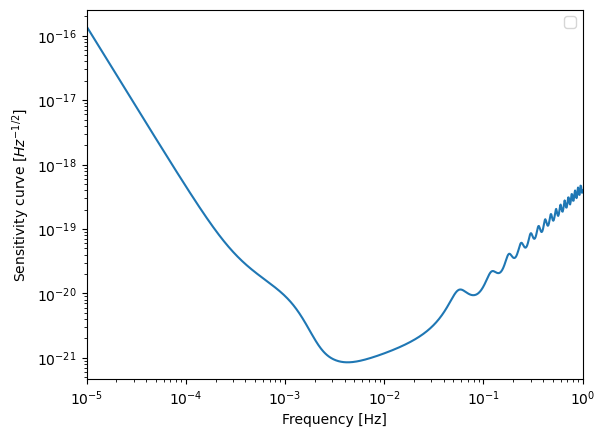

In [2]:
#LISA sensitivity curve 
lisapsd = types.load_frequencyseries("/disk1/home/wrjx/LitePIG/noise/psd_LISA.txt")
plt.loglog(lisapsd.sample_frequencies, np.sqrt((lisapsd.sample_frequencies)*lisapsd))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Sensitivity curve [$Hz^{-1/2}$]')
plt.xlim(1.0e-5,1)
plt.legend()

## 1.1 Set up the parameters of GW

In [3]:
#assume a signal
z=1
m1=2e5
m2=2e4
print('m1,m2',m1,m2)

#dimensionless spins: a=cos(theta_s)*s
chi1 = 0.0
chi2 = 0.0


#t0= np.random.uniform(0.0,5.0)
t0=0.05   #yr

#Ecliptic Longitude, Latitude
theta=1.0
phi=1.5
lambd =  phi 
beta = np.pi/2 -theta
print('lambd,beta',lambd,beta)

inc = 0.5
DL = Cosmology.DL(z, w=0)[0] # in Mpc
print('Dl,inc',DL,inc)

#phi0 = np.random.uniform(0.0, 2.0*np.pi)
#psi = np.random.uniform(0.0, 2.0*np.pi)   
psi=0.8
phi0=0.0
print('t0,phi0,psi',t0,phi0,psi)

# Equal arm orbit: MLCD trajectories 
trajdict = trajdict_MLDC 
# The first-generatrion TDI 
TDItag =  "TDIAET" 


chirp_mass=mchirp_from_mass1_mass2(m1,m2)
q=q_from_mass1_mass2(m1,m2)
print('chirp mass, q ',chirp_mass,q)


#we use the frequency domain waform model: IMRPhenomHM
apx=['SEOBNRv4HM','IMRPhenomHM']
modes=[[[2,2]],[[2,2],[2,1],[3,2],[3,3],[4,4]]] 


m1,m2 200000.0 20000.0
lambd,beta 1.5 0.5707963267948966
Dl,inc 6823.090480179816 0.5
t0,phi0,psi 0.05 0.0 0.8
chirp mass, q  49289.164742357876 10.0


## 1.2 Compute waveform (strain $h_+, h_{\times}$) 

The GW waveform in the transverse-traceless gauge is described by the two polarizations $h_+, h_{\times}$. Furthermore, $h_+, h_{\times}$ can be decomposed into the spherical harmonic modes, $h_{\ell m}$, by using the spin-weighted spherical harmonics as functions of the inclination angle $\iota$ and coalescence phase $\phi_c$. The waveform can be expressed as
$$ h_+ -\mathrm{i} h_{\times} = \sum_{\ell\geq2}\sum_{m=-\ell}^{\ell}\ _{-2}Y_{\ell m}(\iota,\phi_c)h_{\ell m}$$
We can  obtain the expression for positive frequency modes
$$ \tilde{h}_{+,\times}(f) = \sum_{\ell}\sum_{m>0}K^{+,\times}_{\ell m}(\iota,\phi_c)\tilde{h}_{\ell m}(f)$$



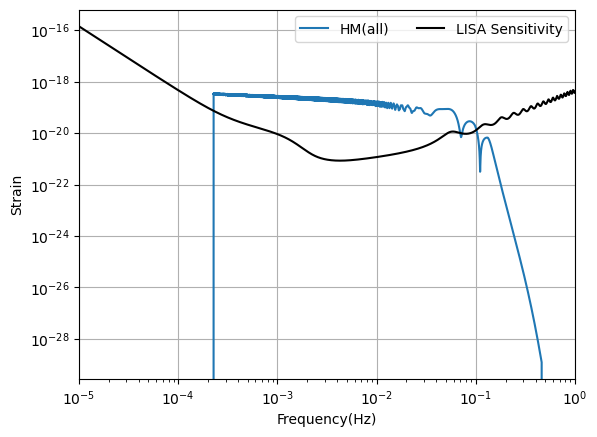

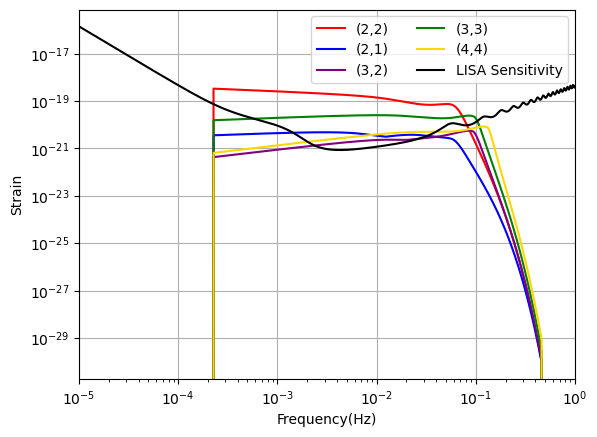

In [4]:
#get a frequency domain waveform 

f,hpf,hcf = gen_signal_fre(chirp_mass,q,DL,inc,phi0,chi1,chi2,apx[1],modes[1],df=2e-7)
plt.loglog(f,abs(hpf)*f,label='HM(all)')
plt.loglog(lisapsd.sample_frequencies, np.sqrt((lisapsd.sample_frequencies)*lisapsd),linestyle='-',color='black',label='LISA Sensitivity')
plt.xlim(1e-5,1)
#plt.ylim(1e-22,1e-17)
plt.legend(ncol=2)
plt.grid()
plt.xlabel('Frequency(Hz)')
plt.ylabel('Strain')
plt.show()

hp ={}
hc ={}
colors=['red','blue','purple','green','gold']
for i in range(len(modes[1])):
    l,m= modes[1][i]
    f,hp[l,m],hc[l,m] = gen_signal_fre(chirp_mass,q,DL,inc,phi0,chi1,chi2,apx[1],[[l,m]],df=2e-7)
    plt.loglog(f,abs(hp[l,m])*f,label='(%d,%d)'%(l,m),color=colors[i])
plt.loglog(lisapsd.sample_frequencies, np.sqrt((lisapsd.sample_frequencies)*lisapsd),linestyle='-',color='black',label='LISA Sensitivity')   
plt.xlim(1e-5,1)
#plt.ylim(1e-22,1e-17)
plt.legend(ncol=2)
plt.grid()
plt.xlabel('Frequency(Hz)')
plt.ylabel('Strain')
plt.show()

The waveform can be expressed in the frequency domain as
$$ h_+ = \frac{d_0}{d_L} \sum_{\ell\geq2}\sum_{m=-\ell}^{\ell}A^{\ell m}_{+}(\iota)e^{im\phi_c}\tilde{h}_{\ell m}$$
$$ h_{\times} = \frac{d_0}{d_L} \sum_{\ell\geq2}\sum_{m=-\ell}^{\ell}A^{\ell m}_{\times}(\iota)ie^{im\phi_c}\tilde{h}_{\ell m}$$
The amplitude of the polarization dependence on inclination angle are different for
each mode.

1.088653079273277


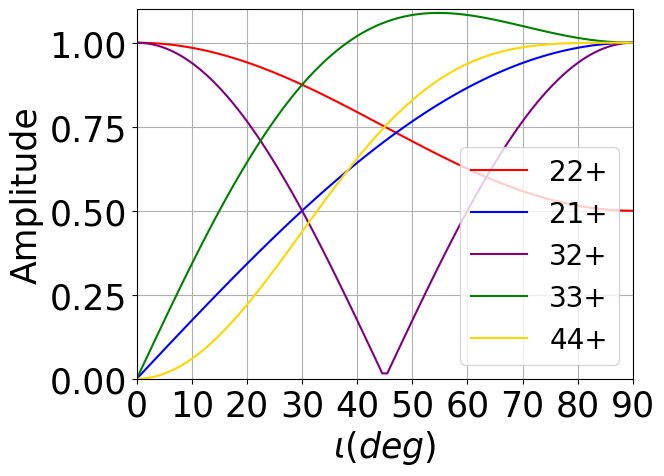

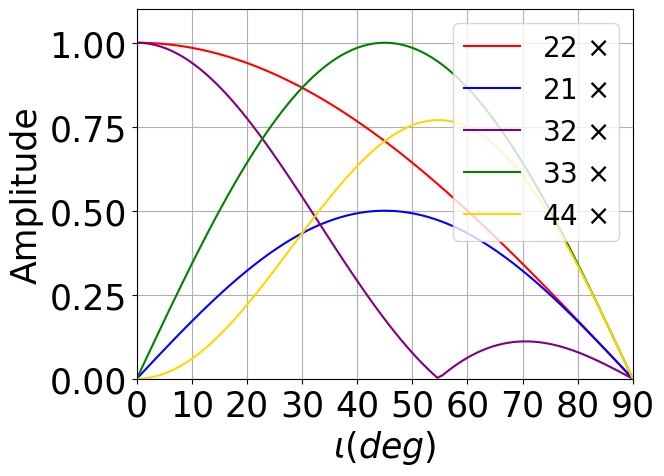

In [5]:
#The amplitudes are the function only of the inclination angle
Aplus = {}
Across = {}
iota =np.linspace(0,np.pi/2,100)
Aplus[2,2] = (1+np.cos(iota)**2)/2
Across[2,2] = np.cos(iota)
Aplus[2,1] = np.sin(iota)
Across[2,1] = np.sin(iota)*np.cos(iota)
Aplus[3,3] = np.sin(iota)*(1+np.cos(iota)**2)
Across[3,3] = 2*np.sin(iota)*np.cos(iota)
Aplus[3,2] = 1- 2* np.cos(iota)**2
Across[3,2] = (np.cos(iota)-3*np.cos(iota)**3)/2
Aplus[4,4] = np.sin(iota)**2*(1+np.cos(iota)**2)
Across[4,4] = 2*np.sin(iota)**2*np.cos(iota)
print(np.max(Aplus[3,3]))
#f, ax = plt.subplots(1, 1, figsize=[12,8])
for i in range(len(modes[1])):
    l,m= modes[1][i]
    plt.plot(iota/np.pi*180,abs(Aplus[l,m]),color=colors[i],label='%d%d+'%(l,m))
plt.xticks([0,10,20,30,40,50,60,70,80,90])
plt.xlim(0,90)
plt.ylim(0,1.1)
plt.ylabel('Amplitude',fontsize=25)
plt.xlabel('$\iota(deg)$',fontsize=25)
plt.tick_params(labelsize=25)
plt.grid()
plt.legend(prop={'size':20})
plt.show()

#f, ax = plt.subplots(1, 1, figsize=[12,8])
for i in range(len(modes[1])):
    l,m= modes[1][i]
    plt.plot(iota/np.pi*180,abs(Across[l,m]),color=colors[i],label='%d%d $\\times$'%(l,m))

plt.xticks([0,10,20,30,40,50,60,70,80,90])
plt.xlim(0,90)
plt.ylim(0,1.1)
plt.ylabel('Amplitude',fontsize=25)
plt.xlabel('$\iota(deg)$',fontsize=25)
plt.tick_params(labelsize=25)
plt.grid()
plt.legend(prop={'size':20})
plt.show()

# 2. TDI response

# 2.1 Compute response with equal_arm orbit

The source frame waveforms can be represented as a combination of harmonics with the amplitude A(f) and phase $\Psi(f)$

$$\tilde{h}_{\ell m}(f) = A_{\ell m}(f)e^{-i\Phi_{\ell m}(f)}$$

The signal of each harmonic and for each TDI channel is given by
$$\tilde{h}^{A,E,T}_{\ell m}(f)= \mathcal{T}^{A,E,T}(f,t_{\ell m}(f))\tilde{h}_{\ell m}(f) $$

In [6]:
#generate the htilde_lm
hlm={} 
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    tmp_htilde=htilde_lm(hp[l,m],l,m,inc,phi0)
    tmp_amp= amplitude_from_frequencyseries(tmp_htilde)
    tmp_phase= phase_from_frequencyseries(tmp_htilde,remove_start_phase=False)
    hlm[l,m]=(tmp_htilde.sample_frequencies,tmp_amp,-tmp_phase+tmp_phase[-1])



2 2
2 1
3 2
3 3
4 4


In [7]:
#generate the htilde_lm
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    hlm[l,m]= get_fd_htilde_lm(chirp_mass,q,DL,inc,phi0,chi1,chi2,apx[1],[[l,m]],df=2e-7)

2 2
2 1
3 2
3 3
4 4


## Generate TDI XYZ/AET

In [8]:
MfCUT = 0.2
Ms = (m1 + m2) * MTSUN_SI
fcut = MfCUT/Ms
print(fcut)




minindex=0
for i in range(len(modes[1])):
    l,m= modes[1][i]
    #print(l,m)
    tmp_minindex = np.argmax(hlm[l,m][2])
    minindex = max(tmp_minindex,minindex)
freq = logsampling(tmp_phase.sample_frequencies[minindex],fcut,1000)


wftdiXYZ={}
wftdiAET={}
for i in range(len(modes[1])):
    l,m= modes[1][i]
    wftdiXYZ[l,m]= get_fd_LISATDI(freq,hlm[l,m],inc,lambd,beta,psi,phi0,[[l,m]],t0=t0, trajdict=trajdict, TDItag='TDIXYZ')
    wftdiAET[l,m]= get_fd_LISATDI(freq,hlm[l,m],inc,lambd,beta,psi,phi0,[[l,m]],t0=t0, trajdict=trajdict, TDItag='TDIAET')



0.1845685850154568


1000001


<function matplotlib.pyplot.show(close=None, block=None)>

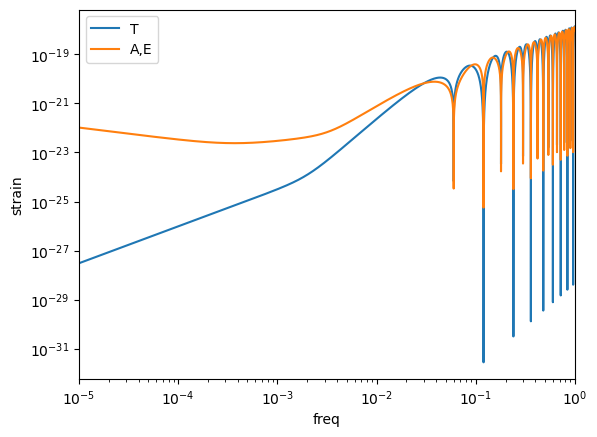

In [9]:
#analytic PSD of noise for TDI A, E and T
del_f= 1e-6
f= np.arange(1e-5,1.0,del_f)
flen = int(1.0/del_f)+1
flow=1e-5
print(flen)
#freq= logsampling(1e-5,1.0,200)
PSD_TDIT= noisepsd_T(f)
PSD_TDIAE= noisepsd_AE(f)
L= 2.5e9/LC.c
PSD_TDIae= PSD_TDIAE/(2*np.sin(2*np.pi*f*L)**2)
PSD_TDIt= PSD_TDIT/(8*np.sin(np.pi*f*L)**2*np.sin(2*np.pi*f*L)**2)
#We can define a strain-like noise PSD
PSD_TDIae= PSD_TDIae/(6*np.pi*f*L)**2
PSD_TDIt= PSD_TDIt/(6*np.pi*f*L)**2

PSD_TDIt = from_numpy_arrays(f, PSD_TDIt, flen, del_f,flow)
PSD_TDIae = from_numpy_arrays(f, PSD_TDIae, flen, del_f,flow)
PSD_TDIT = from_numpy_arrays(f, PSD_TDIT, flen, del_f,flow)
PSD_TDIAE = from_numpy_arrays(f, PSD_TDIAE, flen, del_f,flow)
plt.loglog(PSD_TDIT.sample_frequencies,np.sqrt(PSD_TDIT*PSD_TDIT.sample_frequencies),label='T')
plt.loglog(PSD_TDIAE.sample_frequencies,np.sqrt(PSD_TDIAE*PSD_TDIAE.sample_frequencies),label='A,E')
plt.xlabel('freq')
plt.ylabel('strain')
plt.xlim(1e-5,1e-0)
plt.legend()
plt.show

2 2
2 1
3 2
3 3
4 4


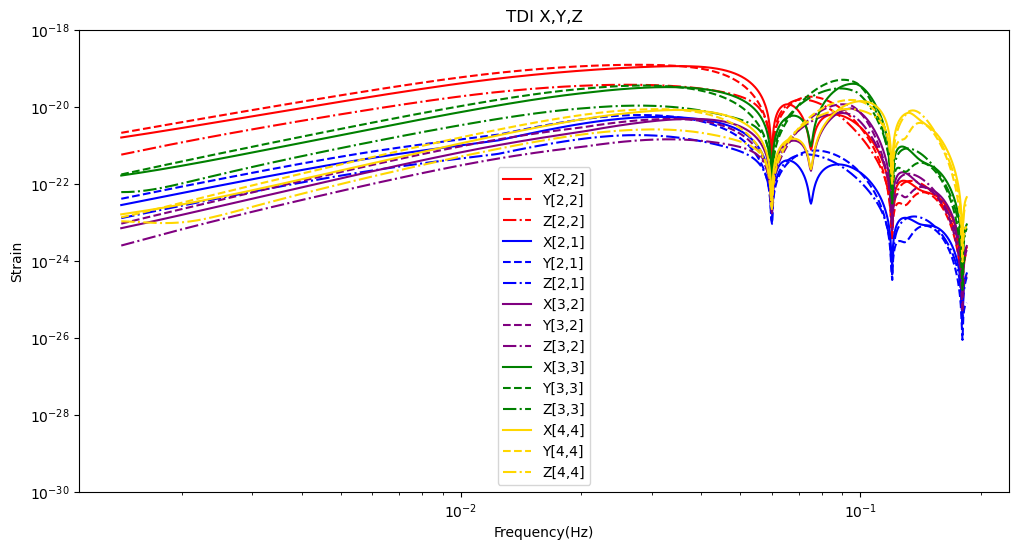

2 2
2 1
3 2
3 3
4 4


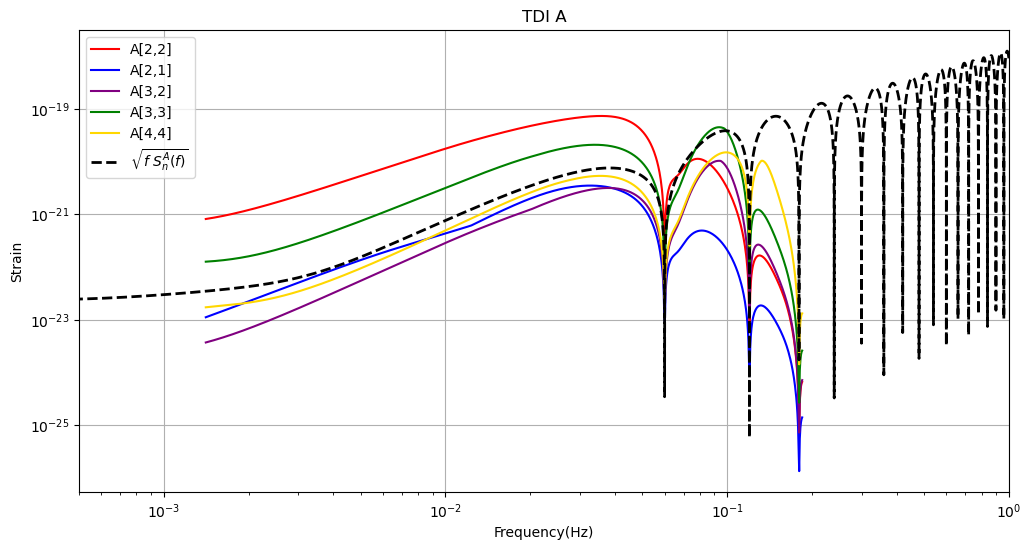

In [10]:
f, ax = plt.subplots(1, 1, figsize=[12,6])
colors=['red','blue','purple','green','gold']
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    #plt.loglog(wftdiAET[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI1'])*wftdiAET[l,m]['freq'],label='A[%d,%d]'%(l,m),linestyle='-',color=colors[i])
    plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI1'])*wftdiXYZ[l,m]['freq'],label='X[%d,%d]'%(l,m),linestyle='-',color=colors[i])
    plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI2'])*wftdiXYZ[l,m]['freq'],label='Y[%d,%d]'%(l,m),linestyle='--',color=colors[i])
    plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI3'])*wftdiXYZ[l,m]['freq'],label='Z[%d,%d]'%(l,m),linestyle='-.',color=colors[i])
plt.xlabel('Frequency(Hz)')
plt.ylabel('Strain')
plt.ylim(1e-30,1e-18)
plt.title('TDI X,Y,Z')
plt.legend()
plt.show()

f, ax = plt.subplots(1, 1, figsize=[12,6])

for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    plt.loglog(wftdiAET[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI1'])*wftdiAET[l,m]['freq'],label='A[%d,%d]'%(l,m),linestyle='-',color=colors[i])
    #plt.loglog(wftdiAET[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI2'])*wftdiAET[l,m]['freq'],label='E[%d,%d]'%(l,m),linestyle='--',color=colors[i])
    #plt.loglog(wftdiAET[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI3'])*wftdiAET[l,m]['freq'],label='T[%d,%d]'%(l,m),linestyle='-.',color=colors[i])
    #plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI2'])*wftdiXYZ[l,m]['freq'],label='X[%d,%d]'%(l,m),linestyle='--',color=colors[i])
plt.loglog(PSD_TDIAE.sample_frequencies,np.sqrt(PSD_TDIAE*PSD_TDIAE.sample_frequencies),linestyle='--',linewidth=2,color='black',label='$\sqrt{f\ S^{A}_{n}(f)}$')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Strain')
plt.xlim(5e-4,1e0)
#plt.ylim(1e-30,1e-18)
plt.title('TDI A')
plt.legend()
plt.grid()

plt.show()

2 2
2 1
3 2
3 3
4 4


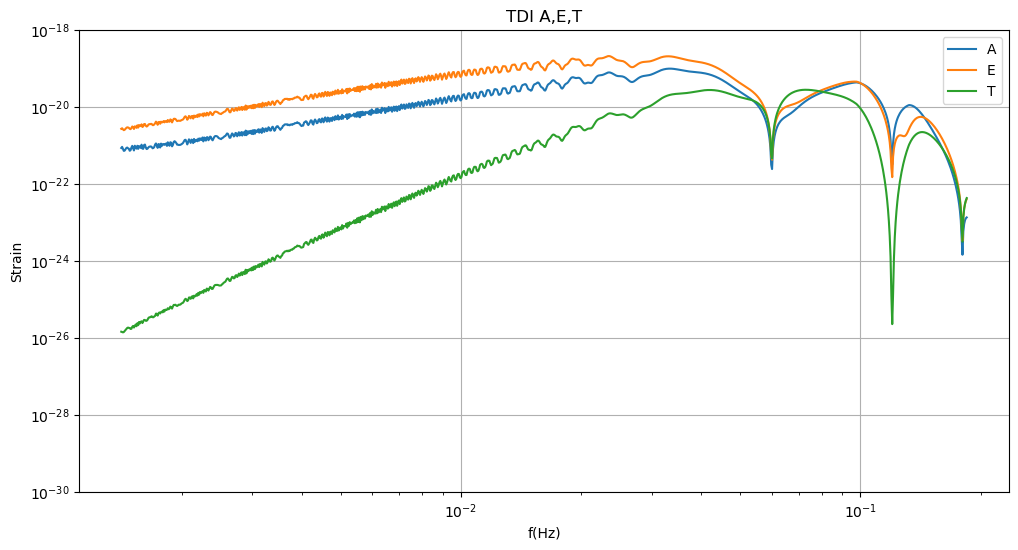

In [11]:
#sum of all modes
TDIA= np.zeros(len(freq), dtype='complex128')
TDIE= np.zeros(len(freq), dtype='complex128')
TDIT= np.zeros(len(freq), dtype='complex128')
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    TDIA += wftdiAET[l,m]['TDI1']
    TDIE += wftdiAET[l,m]['TDI2']
    TDIT += wftdiAET[l,m]['TDI3']

f, ax = plt.subplots(1, 1, figsize=[12,6])
plt.loglog(freq,np.abs(TDIA*freq),label='A',linestyle='-')
plt.loglog(freq,np.abs(TDIE*freq),label='E',linestyle='-')
plt.loglog(freq,np.abs(TDIT*freq),label='T',linestyle='-')
plt.grid()
plt.xlabel('f(Hz)')
plt.ylabel('Strain')
plt.ylim(1e-30,1e-18)
plt.title('TDI A,E,T')
plt.legend()
plt.show()

## Interpolation of each modes

In [12]:
del_t = 1.0
fsample_SMBH = 1./del_t
fnyquist_SMBH = 1./2*fsample_SMBH     #
df = 2e-7
f0 = np.floor(freq[0]/df)*df
print('fmin, fmax',f0,fcut)

n_SMBH= int((freq[-1]-f0)/df)
print('df, num',df,n_SMBH) 
freqs_SMBH = df*np.arange(n_SMBH) +f0
freqs_SMBH = freqs_SMBH[(freqs_SMBH>=freq[0]) & (freqs_SMBH<=fnyquist_SMBH)]

wftdiAET_int={}
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    wftdiAET_int[l,m] = func_wfTDI(freqs_SMBH, wftdiAET[l,m])



fmin, fmax 0.0014102 0.1845685850154568
df, num 2e-07 915791
2 2
2 1
3 2
3 3
4 4


In [13]:
#sum of all modes
Nf = int (fnyquist_SMBH/df +1)
fre = df*np.arange(Nf)
i_b = int(np.rint(freqs_SMBH[0]/df))
TDI1 = np.zeros(Nf, dtype='complex128')
TDI2 = np.zeros(Nf, dtype='complex128')
TDI3 = np.zeros(Nf, dtype='complex128')

for i in range(len(modes[1])):
    l,m= modes[1][i]
    TDI1[i_b:len(freqs_SMBH)+ i_b] += wftdiAET_int[l,m]['TDI1']
    TDI2[i_b:len(freqs_SMBH)+i_b] += wftdiAET_int[l,m]['TDI2']
    TDI3[i_b:len(freqs_SMBH)+i_b] += wftdiAET_int[l,m]['TDI3']

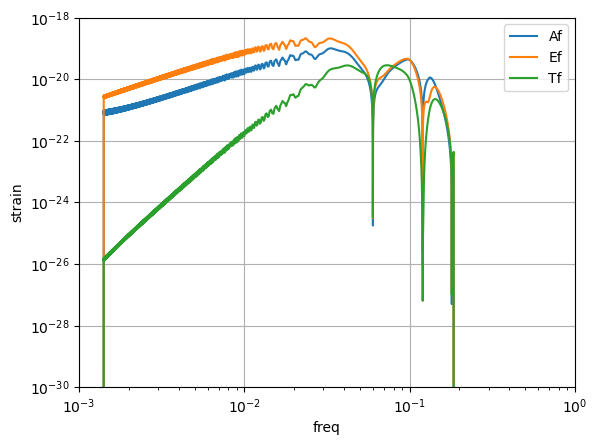

In [14]:
#f, ax = plt.subplots(1, 1, figsize=[12,6])
plt.loglog(fre,np.abs(TDI1*fre),label='Af',linestyle='-')
plt.loglog(fre,np.abs(TDI2*fre),label='Ef',linestyle='-')
plt.loglog(fre,np.abs(TDI3*fre),label='Tf',linestyle='-')
# plt.loglog(PSD_TDIT.sample_frequencies,np.sqrt(PSD_TDIT*PSD_TDIT.sample_frequencies),label='T')
# plt.loglog(PSD_TDIAE.sample_frequencies,np.sqrt(PSD_TDIAE*PSD_TDIAE.sample_frequencies),label='A,E')
plt.xlabel('freq')
plt.ylabel('strain')
plt.legend()
plt.grid()
plt.ylim(1e-30,1e-18)
plt.xlim(1e-3,1e-0)
plt.show()


In [15]:
palette = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD"]
def plot_wf_tdi_all(wf, scalebyf2=False):
    fig, ax = plt.subplots(3, 3, figsize=(16,12))
    f, amp, phase, phaseRdelay, transferL1, transferL2, transferL3, TDI1, TDI2, TDI3, TDItag = wf['freq'], wf['amp'], wf['phase'], wf['phaseRdelay'], wf['transferL1'], wf['transferL2'], wf['transferL3'], wf['TDI1'], wf['TDI2'], wf['TDI3'], wf['TDItag']
    # Common settings
    for i in range(3):
        for j in range(3):
            ax[i][j].set_xlim(min(f), max(f))
            ax[i][j].set_xscale('log')
            ax[i][j].set_xlabel(r'f (Hz)')
            ax[i][j].grid()
    # Amp
    ax[0][0].plot(f, amp, color=palette[0])
    ax[0][0].set_yscale('log')
    ax[0][0].set_ylabel(r'$A_{22}$')
    ax[0][0].set_title(r'Amplitude')
    # Phase
    ax[0][1].plot(f, phase, color=palette[0])
    ax[0][1].set_xscale('log')
    ax[0][1].set_ylabel(r'$\Phi_{22}$')
    ax[0][1].set_title(r'Phase')
    # Orbital delay phase
    ax[0][2].plot(f, phaseRdelay, color=palette[0])
    ax[0][2].set_xscale('log')
    ax[0][2].axhline(0, color='k')
    ax[0][2].set_ylabel(r'$\Phi_{d_0}$')
    ax[0][2].set_title(r'Orbital delay phase')
    # TDI and transfer
    transL = {}
    if scalebyf2:
        fstar = C_SI/L_SI
        transL[1], transL[2], transL[3] = transferL1*(fstar/f)**2, transferL2*(fstar/f)**2, transferL3*(fstar/f)**2
    else:
        transL[1], transL[2], transL[3] = transferL1, transferL2, transferL3
    tdi = {}
    tdi[1], tdi[2], tdi[3] = TDI1, TDI2, TDI3
    # Labels
    tdilabel = {}
    if TDItag=='TDIXYZ':
        tdilabel[1] = 'X'
        tdilabel[2] = 'Y'
        tdilabel[3] = 'Z'
    elif TDItag=='TDIAET':
        tdilabel[1] = 'A'
        tdilabel[2] = 'E'
        tdilabel[3] = 'T'
    else:
        raise ValueError("Error in plot_wf_tdi: TDItag not recognized.")
    ylabeltrans = {}; titletrans = {}; ylabeltdi = {}; titletdi = {};
    for i in range(1,4):
        if scalebyf2:
            ylabeltrans[i] = r'$(f_{*}/f)^2\mathcal{T}^L_'+tdilabel[i]+'$'
        else:
            ylabeltrans[i] = r'$\mathcal{T}^L_'+tdilabel[i]+'$'
        titletrans[i] = r'Transfer '+tdilabel[i]+' Re/Im'
        ylabeltdi[i] = r'$\mathrm{TDI}_'+tdilabel[i]+'$'
        titletdi[i] = r'TDI '+tdilabel[i]+' Re/Im'
    # Plot transfer
    for i in range(1,4):
        ax[1][i-1].plot(f, np.real(transL[i]), color=palette[0],label='Re')
        ax[1][i-1].plot(f, np.imag(transL[i]), color=palette[1],label='Im')
        ax[1][i-1].axhline(0, color='k')
        ax[1][i-1].set_ylabel(ylabeltrans[i])
        ax[1][i-1].set_title(titletrans[i])
        ax[1][i-1].legend()
    # Plot TDI
    for i in range(1,4):
        ax[2][i-1].plot(f, np.real(tdi[i]), color=palette[0],label='Re')
        ax[2][i-1].plot(f, np.imag(tdi[i]), color=palette[1],label='Im')
        ax[2][i-1].axhline(0, color='k')
        ax[2][i-1].set_ylabel(ylabeltdi[i])
        ax[2][i-1].set_title(titletdi[i])
        ax[2][i-1].legend()
    plt.tight_layout()
    plt.show()

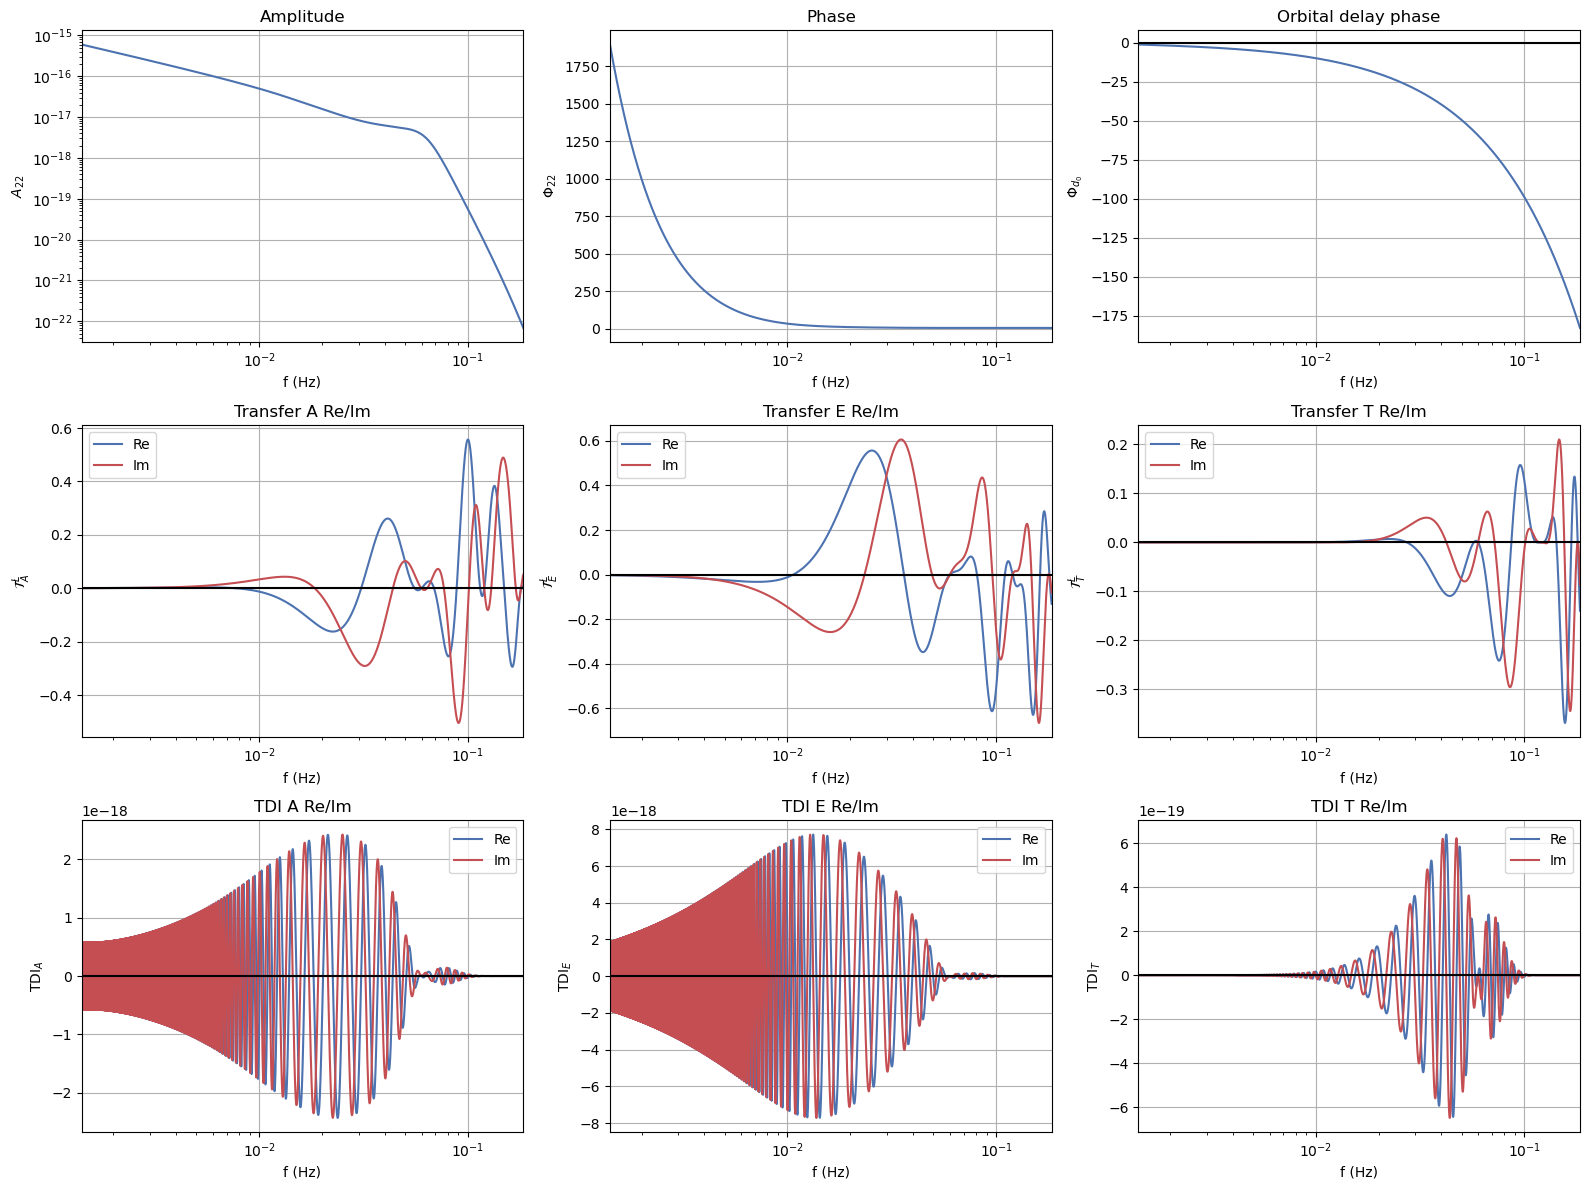

In [16]:
l,m= 2,2
plot_wf_tdi_all(wftdiAET_int[l,m], scalebyf2=False)

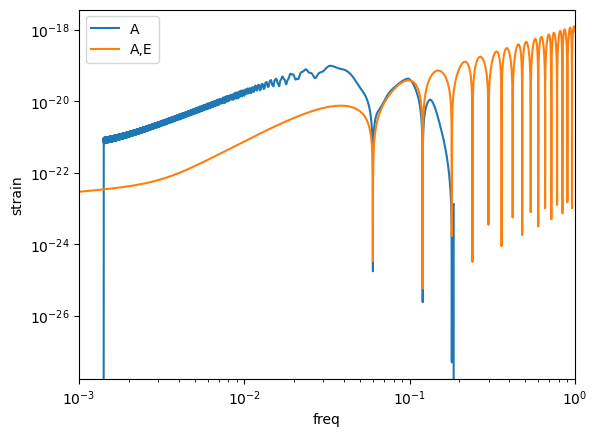

In [17]:
freqs, A,E,T =get_TDI(chirp_mass,q,DL,inc,phi0,chi1,chi2,lambd,beta,psi,t0,trajdict,TDItag,apx[1],modes[1],df=2e-7,del_t=1.0)
plt.loglog(freqs,np.abs(A*freqs),label='A',linestyle='-')
plt.loglog(PSD_TDIAE.sample_frequencies,np.sqrt(PSD_TDIAE*PSD_TDIAE.sample_frequencies),label='A,E')
plt.xlabel('freq')
plt.ylabel('strain')
plt.legend()
plt.xlim(1e-3,1e-0)
plt.show()

# Compute the SNR

In [18]:
TDIA= types.FrequencySeries(A,delta_f=freqs[1]-freqs[0])
TDIE= types.FrequencySeries(E,delta_f=freqs[1]-freqs[0])
TDIT= types.FrequencySeries(T,delta_f=freqs[1]-freqs[0])


psdAE = estimate.interpolate(PSD_TDIAE,TDIA.delta_f)
psdT  = estimate.interpolate(PSD_TDIT,TDIT.delta_f)


SNR=sigmasq(TDIA,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-1)+\
    sigmasq(TDIE,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-1)+\
    sigmasq(TDIT,psd=psdT,low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-1)
print(np.sqrt(SNR))

428.43831448687126


# The low-frequency limit
Here, we use the low-frequency approximation to the LISA response.
In the low-frequency approximation, the T-channel can be neglected and the response for the other two TDI observables are given by 
$$\tilde{h}_{a,e} = F^{+}_{a,e}(\lambda_L,\beta_L,\psi_L)\tilde{h}_{+} + F^{\times}_{a,e}(\lambda_L,\beta_L,\psi_L)\tilde{h}_{\times} $$

Here we rescale the TDI observables by prefactors. The TDI channels in the frequency domain can be written as
$$\tilde{a},\tilde{e} = \frac{e^{-2\mathrm{i} \pi fL}}{\mathrm{i} \sqrt{2}{\rm sin}(2\pi fL)}\times \tilde{A},\tilde{E}$$
$$\tilde{t} = \frac{e^{-3\mathrm{i}\pi fL}}{2\sqrt{2}{\rm sin}(\pi fL){\rm sin}(2\pi fL)}\times \tilde{T} $$

It is also useful to introduce the following natations
$$\tilde{h}_{a,e,t} = \frac{1}{-6\mathrm{i} \pi fL} \times \tilde{a},\tilde{e},\tilde{t}$$


In [19]:
#response function
def FLISA(t,lambd,beta,psi,t0):
    alpha= 2*np.pi*(t-t0)      #t,t0: yr
    #print(alpha)
    beta_L= np.arcsin(np.cos(np.pi/3)*np.sin(beta)-np.sin(np.pi/3)*np.cos(beta)*np.cos(lambd-alpha))
    lambd_L= arctan(np.cos(beta)*np.cos(lambd)*(np.cos(np.pi/3)*np.cos(alpha)**2+np.sin(alpha)**2)+\
                    np.cos(beta)*np.sin(lambd)*np.cos(alpha)*np.sin(alpha)*(np.cos(np.pi/3)-1)+\
                    np.sin(np.pi/3)*np.sin(beta)*np.cos(alpha)+\
                    np.cos(beta)*np.sin(lambd)*(np.cos(np.pi/3)*np.sin(alpha)**2+np.cos(alpha)**2)+\
                    np.cos(beta)*np.cos(lambd)*np.cos(alpha)*np.sin(alpha)*(np.cos(np.pi/3)-1)+
                    np.sin(np.pi/3)*np.sin(beta)*np.sin(alpha))
    psi_L= psi +np.arctan(np.cos(pi/3)*np.cos(beta)+np.sin(np.pi/3)*np.sin(beta)*np.cos(lambd-alpha)-np.sin(np.pi/3)*np.sin(lambd-alpha))

    F_a_plus = (1+np.sin(beta_L)**2)*np.cos(2*lambd_L-np.pi/3)/2
    F_a_cross = np.sin(beta_L)*np.sin(2*lambd_L-np.pi/3)
    F_e_plus = (1+np.sin(beta_L)**2)*np.cos(2*lambd_L+np.pi/6)/2
    F_e_cross = np.sin(beta_L)*np.sin(2*lambd_L+np.pi/6)
    #include the polarization angle in the pattern function
    Fa_plus = np.cos(2*psi_L)*F_a_plus + np.sin(2*psi_L) *F_a_cross
    Fe_plus = np.cos(2*psi_L)*F_e_plus + np.sin(2*psi_L) *F_e_cross
    Fa_cross = -np.sin(2*psi_L)*F_a_plus + np.cos(2*psi_L) *F_a_cross
    Fe_cross = -np.sin(2*psi_L)*F_e_plus + np.cos(2*psi_L) *F_e_cross
    return Fa_plus,Fa_cross,Fe_plus,Fe_cross

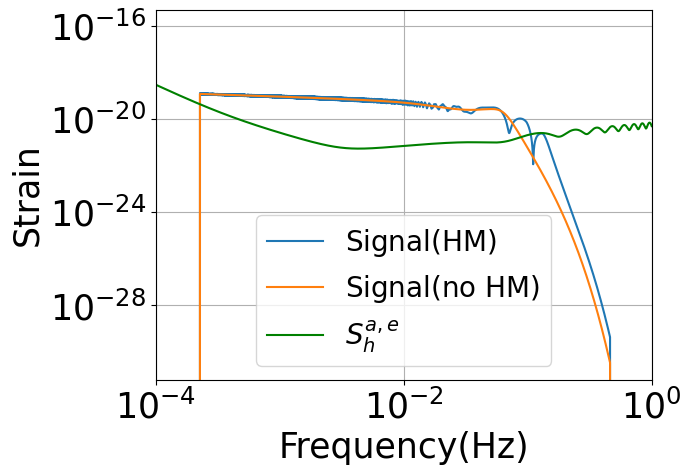

In [20]:
#get a frequency domain waveform htilde_a, htilde_e
Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,lambd,beta,psi,0)
htilde_a = Fa_plus*hpf + Fa_cross*hcf
htilde_e = Fe_plus*hpf + Fe_cross*hcf
htilde_a_noHM = Fa_plus*hp[2,2] + Fa_cross*hc[2,2]
htilde_e_noHM = Fe_plus*hp[2,2] + Fe_cross*hc[2,2]

#f, ax = plt.subplots(1, 1, figsize=[12,8])
plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_a.sample_frequencies,label='$\\rm Signal(HM)$')
plt.loglog(htilde_a_noHM.sample_frequencies,abs(htilde_a_noHM)*htilde_a_noHM.sample_frequencies,label='$\\rm Signal(no\ HM)$')
#plt.loglog(htilde_e.sample_frequencies,abs(htilde_e)*htilde_e.sample_frequencies,label='$h_e^(LF)(HM)$')
#plt.loglog(htilde_e_noHM.sample_frequencies,abs(htilde_e_noHM)*htilde_e_noHM.sample_frequencies,label='$h_e^{LF}(no HM)$')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),color='green',linestyle='-',label='$S^{a,e}_{h}$')
plt.legend(prop={'size':20})
plt.xlim(1e-4,1e-0)
#plt.ylim(1e-26,1e-17)
plt.grid()
plt.xlabel('Frequency(Hz)',fontsize=25)
plt.ylabel('Strain',fontsize=25)
plt.tick_params(labelsize=25)

plt.show()

# 2.2 Compute response with unequal_arm orbit

Download orbit file.


In [21]:
#solar equatorial coordinate system
path ='/disk1/home/wrjx/LitePIG/signal'
# print(path)
p1 = np.fromfile(path+'/LISA_orbit_data/SCP1_1yr.dat',sep=' ')
p2 = np.fromfile(path+'/LISA_orbit_data/SCP2_1yr.dat',sep=' ')
p3 = np.fromfile(path+'/LISA_orbit_data/SCP3_1yr.dat',sep=' ')
# print(p1)
# print(len(p1))
p1= p1.reshape(int(len(p1)/3),3)
p2= p2.reshape(int(len(p2)/3),3)
p3= p3.reshape(int(len(p3)/3),3)

# fig=plt.figure()
# plt.gcf().set_size_inches(14,10) 
# ax = Axes3D(fig)
# ax.scatter(p1[:,0],p1[:,1],p1[:,2],color='red')
# ax.scatter(p2[:,0],p2[:,1],p2[:,2],color='blue')
# ax.scatter(p3[:,0],p3[:,1],p3[:,2],color='orange')
# ax.view_init(elev=15,azim=10)
# plt.legend()
# plt.show()

#equatorial coordinate system 
c1= SkyCoord(x=p1[:,0],y=p1[:,1],z=p1[:,2],unit=u.au,frame='icrs',representation_type='cartesian')
c2= SkyCoord(x=p2[:,0],y=p2[:,1],z=p2[:,2],unit=u.au,frame='icrs',representation_type='cartesian')
c3= SkyCoord(x=p3[:,0],y=p3[:,1],z=p3[:,2],unit=u.au,frame='icrs',representation_type='cartesian')
#print(c1)
#transfrom to Ecliptic system of coordinate
p1_SSB= c1.heliocentrictrueecliptic
p2_SSB= c2.heliocentrictrueecliptic
p3_SSB= c3.heliocentrictrueecliptic
p1_SSB.representation_type='cartesian'
p2_SSB.representation_type='cartesian'
p3_SSB.representation_type='cartesian'

trajdict_numerical_orbits = {
    'funcp0':funcp0_SSB,
    'funcp': funcp_SSB,
    'funcL': funcL_SSB,
    'p1_SSB': p1_SSB,
    'p2_SSB': p2_SSB,
    'p3_SSB': p3_SSB,
    }

tmp_year=np.linspace(0,LC.YRSID_SI,100)
tmp_p0 = funcp0_SSB(tmp_year,p1_SSB=p1_SSB,p2_SSB=p2_SSB,p3_SSB=p3_SSB)
tmp_p1= funcp_SSB(tmp_year,p1_SSB)
tmp_p2= funcp_SSB(tmp_year,p2_SSB)
tmp_p3= funcp_SSB(tmp_year,p3_SSB)
L12= funcL_SSB(tmp_p1,tmp_p2)
L23= funcL_SSB(tmp_p2,tmp_p3)
L13= funcL_SSB(tmp_p1,tmp_p3)
plt.plot(tmp_year,L12*R_SI/1e9,label='$L_{12}$')
plt.plot(tmp_year,L23*R_SI/1e9,label='$L_{23}$')
plt.plot(tmp_year,L13*R_SI/1e9,label='$L_{13}$')
plt.xlabel('Time')
plt.ylabel('Arm Length($10^9$ m)')
plt.legend()

NameError: name 'funcp0_SSB' is not defined

## Generate TDI XYZ/AET

In [ ]:
M1 = m1+m2
fmax = 0.6 /(M1*MTSUN_SI)
fmin = 1e-4 / (M1*MTSUN_SI)
print(fmin, fmax)
hlm = {}
tmp_fmin=1e-5
for i in range(len(modes[1])):
    l,m= modes[1][i]
    #print(l,m)
    # f = logsampling(fmin,fmax,int(5*10**4*m*l/2))
    f1 = logsampling(fmin,fmin*1e2,int(2*10**4*m*l/2))
    f2 = np.linspace(fmin*1e2,fmax,int(1000))
    f2 = np.delete(f2,0)
    f = np.hstack((f1,f2))
    fre = types.array.Array(f)
    hlm[l,m]= get_fd_sequence_htilde_lm(fre,chirp_mass,q,DL,inc,phi0,chi1,chi2,apx[1],[modes[1][i]])
    tmp_minindex = np.argmax(hlm[l,m][2])
    tmp_fmin = max(fre[tmp_minindex],tmp_fmin)

9.22842925077284e-05 0.5537057550463704


In [ ]:
freq = logsampling(tmp_fmin,fmax,1000)
tdiXYZ_EQ={}
tdiXYZ_unEQ={}
#tdiXYZ_unEQ_EQ={}
TDItag='TDIXYZ'
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    tdiXYZ_EQ[l,m]= FDresponseTDI(freq,hlm[l,m],inc,lambd,beta,psi,phi0,[[l,m]],t0=t0, trajdict=trajdict, TDItag=TDItag,number_orbits=False,TDI_froze_arm=True,frozenLISA=True,rescaled=False)
    #tdiXYZ_unEQ_EQ[l,m]= FDresponseTDI(freq,hlm[l,m],inc,lambd,beta,psi,phi0,[[l,m]],t0=t0, trajdict=trajdict_numerical_orbits, TDItag=TDItag,number_orbits=True,TDI_froze_arm=True,frozenLISA=True,rescaled=False,responseapprox='full')
    tdiXYZ_unEQ[l,m]= FDresponseTDI(freq,hlm[l,m],inc,lambd,beta,psi,phi0,[[l,m]],t0=t0, trajdict=trajdict_numerical_orbits, TDItag=TDItag,number_orbits=True,TDI_froze_arm=False,frozenLISA=True,rescaled=False)



2 2
2 1
3 2
3 3
4 4


2 2


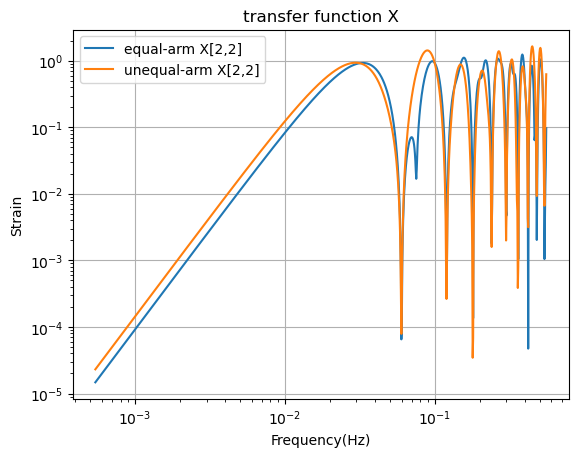

2 1


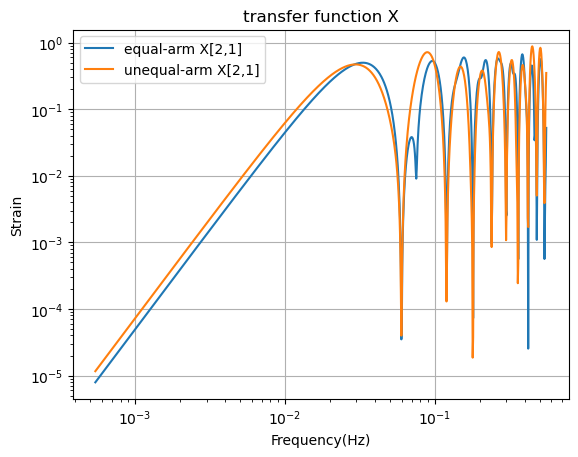

3 2


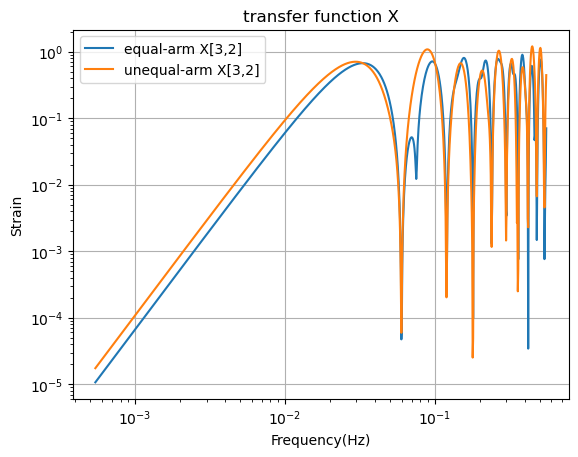

3 3


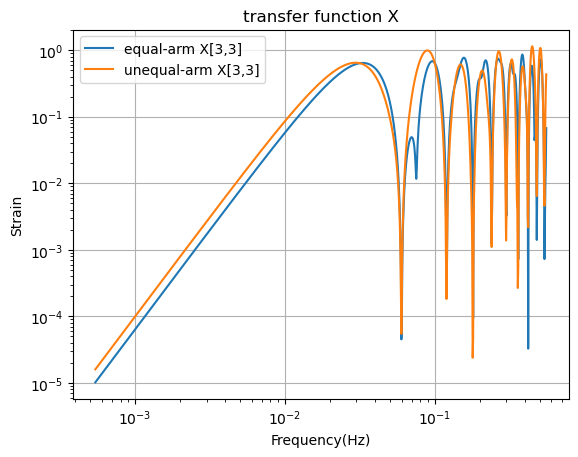

4 4


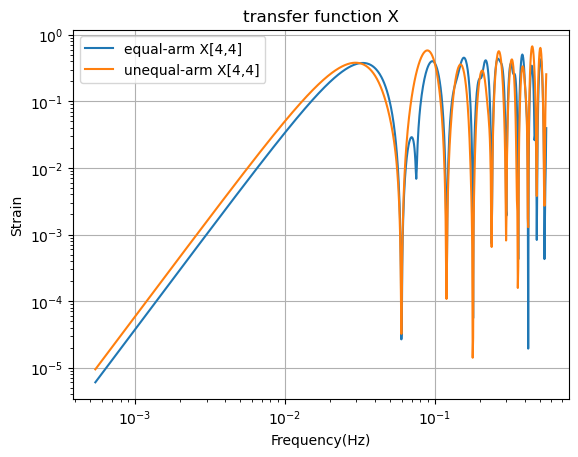

2 2


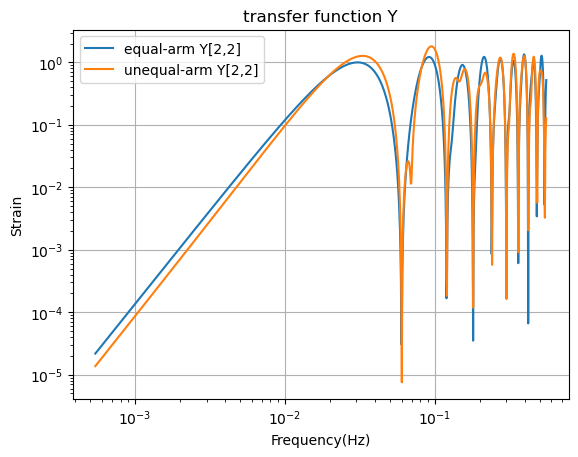

2 1


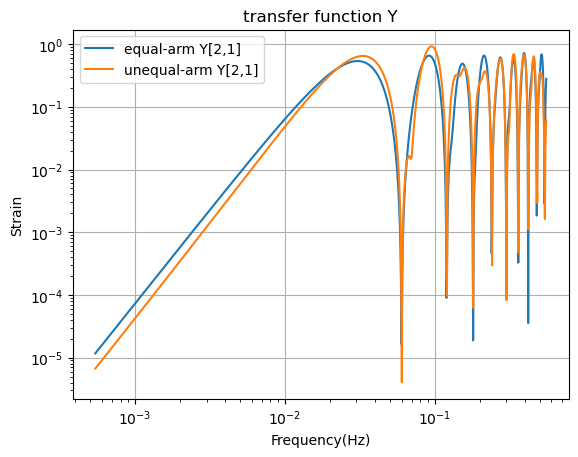

3 2


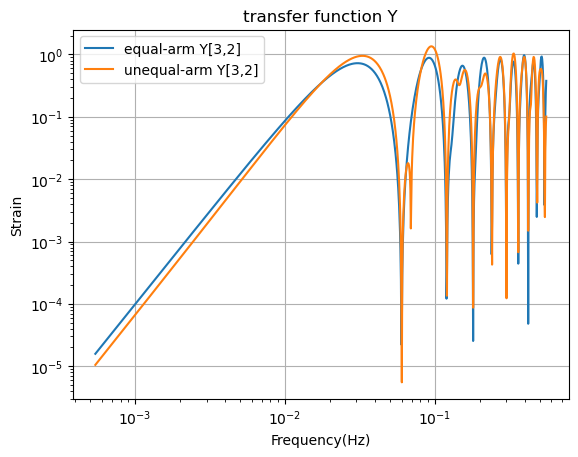

3 3


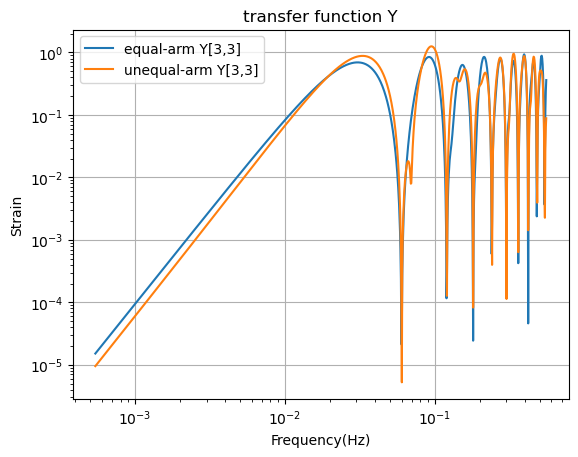

4 4


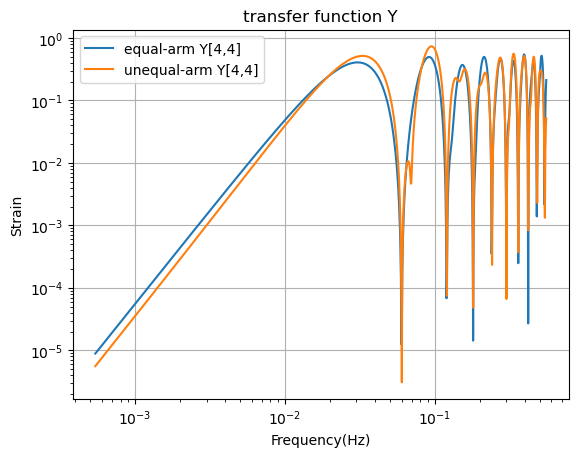

2 2


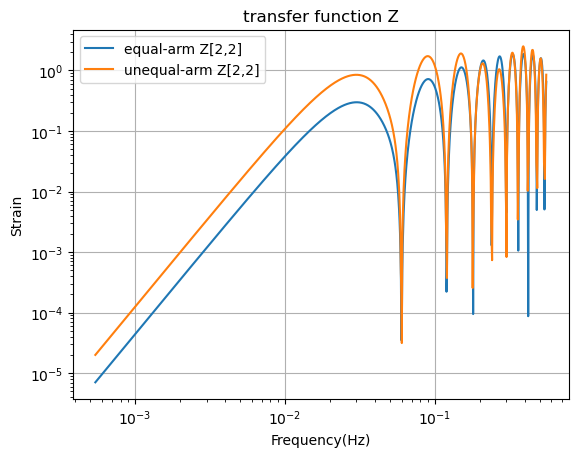

2 1


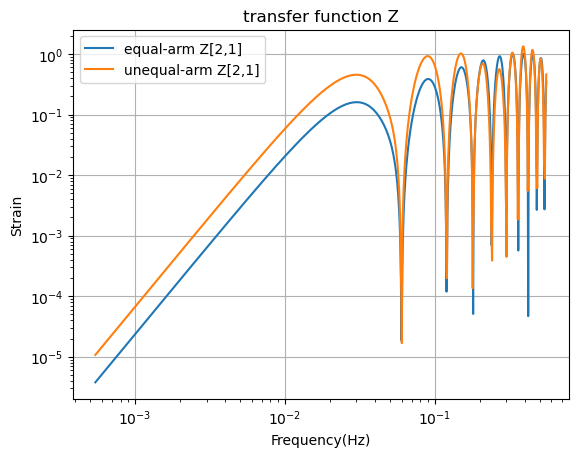

3 2


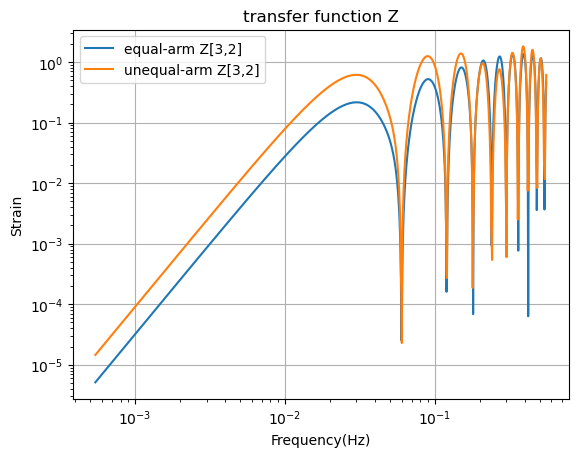

3 3


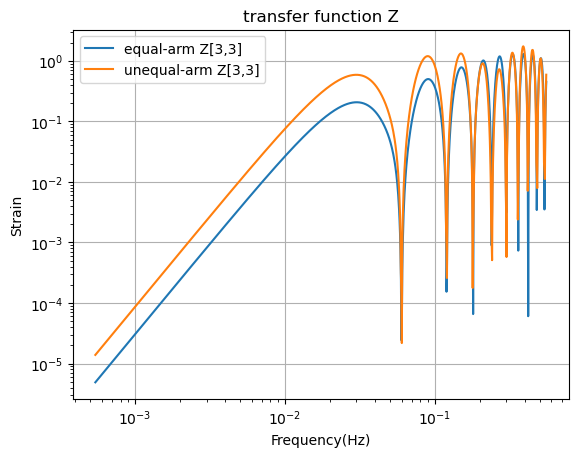

4 4


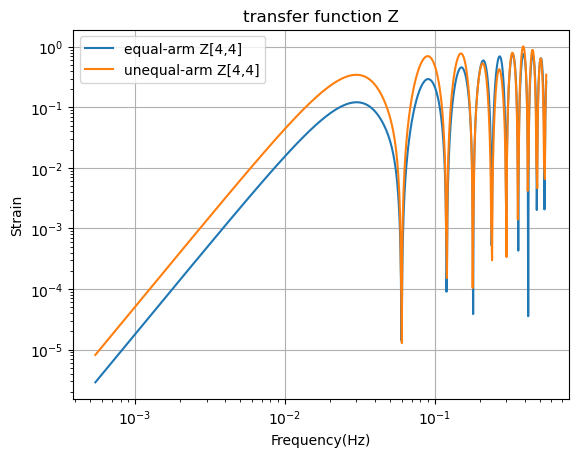

In [ ]:
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    plt.loglog(tdiXYZ_EQ[l,m]['freq'], np.abs(tdiXYZ_EQ[l,m]['transferL1']),label='equal-arm X[%d,%d]'%(l,m),linestyle='-')
    # plt.loglog(tdiXYZ_unEQ_EQ[l,m]['freq'], np.abs(tdiXYZ_unEQ_EQ[l,m]['transferL1']),label='Proj. bais X[%d,%d]'%(l,m),linestyle='-')
    plt.loglog(tdiXYZ_unEQ[l,m]['freq'], np.abs(tdiXYZ_unEQ[l,m]['transferL1']),label='unequal-arm X[%d,%d]'%(l,m),linestyle='-')
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Strain')
    #plt.xlim(5e-4,1e0)
#plt.ylim(1e-30,1e-18)
    plt.title('transfer function X')
    plt.legend()
    plt.grid()
    plt.show()
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    plt.loglog(tdiXYZ_EQ[l,m]['freq'], np.abs(tdiXYZ_EQ[l,m]['transferL2']),label='equal-arm Y[%d,%d]'%(l,m),linestyle='-')
    # plt.loglog(tdiXYZ_unEQ_EQ[l,m]['freq'], np.abs(tdiXYZ_unEQ_EQ[l,m]['transferL2']),label='Proj. bais Y[%d,%d]'%(l,m),linestyle='-')
    plt.loglog(tdiXYZ_unEQ[l,m]['freq'], np.abs(tdiXYZ_unEQ[l,m]['transferL2']),label='unequal-arm Y[%d,%d]'%(l,m),linestyle='-')
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Strain')
    #plt.xlim(5e-4,1e0)
#plt.ylim(1e-30,1e-18)
    plt.title('transfer function Y')
    plt.legend()
    plt.grid()
    plt.show()

for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    plt.loglog(tdiXYZ_EQ[l,m]['freq'], np.abs(tdiXYZ_EQ[l,m]['transferL3']),label='equal-arm Z[%d,%d]'%(l,m),linestyle='-')
    # plt.loglog(tdiXYZ_unEQ_EQ[l,m]['freq'], np.abs(tdiXYZ_unEQ_EQ[l,m]['transferL3']),label='Proj. bais Z[%d,%d]'%(l,m),linestyle='-')
    plt.loglog(tdiXYZ_unEQ[l,m]['freq'], np.abs(tdiXYZ_unEQ[l,m]['transferL3']),label='unequal-arm Z[%d,%d]'%(l,m),linestyle='-')
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Strain')
    #plt.xlim(5e-4,1e0)
#plt.ylim(1e-30,1e-18)
    plt.title('transfer function Z')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
tdiAET_EQ={}
tdiAET_unEQ={}
# tdiAET_unEQ_EQ={}
TDItag='TDIAET'
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    tdiAET_EQ[l,m]= FDresponseTDI(freq,hlm[l,m],inc,lambd,beta,psi,phi0,[[l,m]],t0=t0, trajdict=trajdict, TDItag=TDItag,number_orbits=False,TDI_froze_arm=True,frozenLISA=True,rescaled=False,responseapprox='full')
    # tdiAET_unEQ_EQ[l,m]= FDresponseTDI(freq,hlm[l,m],inc,lambd,beta,psi,phi0,[[l,m]],t0=t0, trajdict=trajdict_numerical_orbits, TDItag=TDItag,TDI_froze_arm=True,frozenLISA=True,rescaled=False,responseapprox='full')
    tdiAET_unEQ[l,m]= FDresponseTDI(freq,hlm[l,m],inc,lambd,beta,psi,phi0,[[l,m]],t0=t0, trajdict=trajdict_numerical_orbits, TDItag=TDItag,number_orbits=True,TDI_froze_arm=False,frozenLISA=True,rescaled=False,responseapprox='full')

# for i

2 2
2 1
3 2
3 3
4 4


2 2


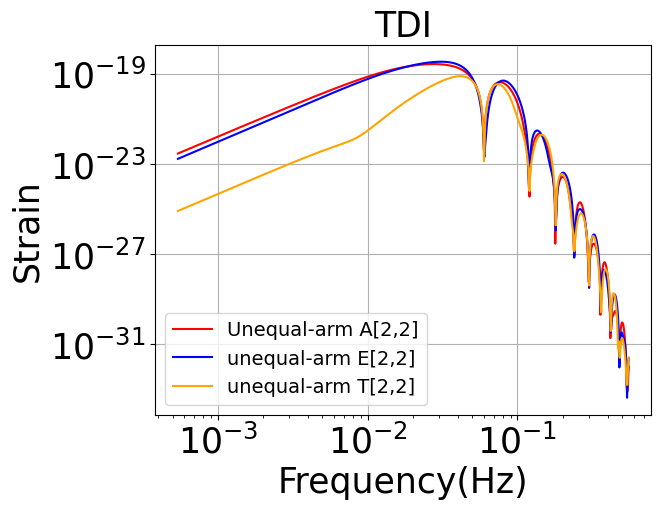

2 1


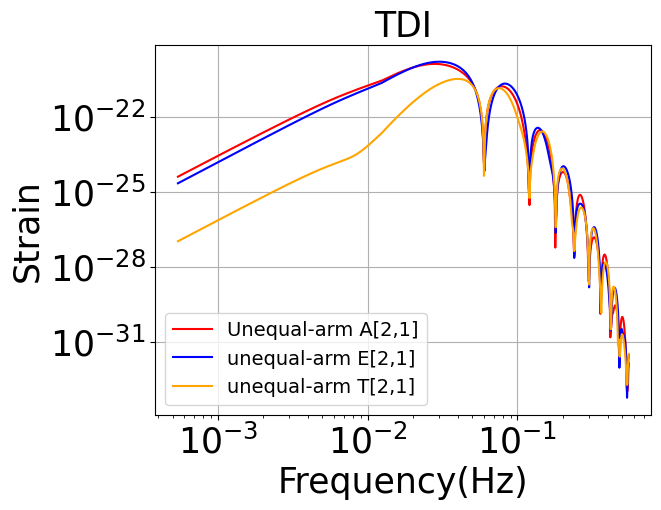

3 2


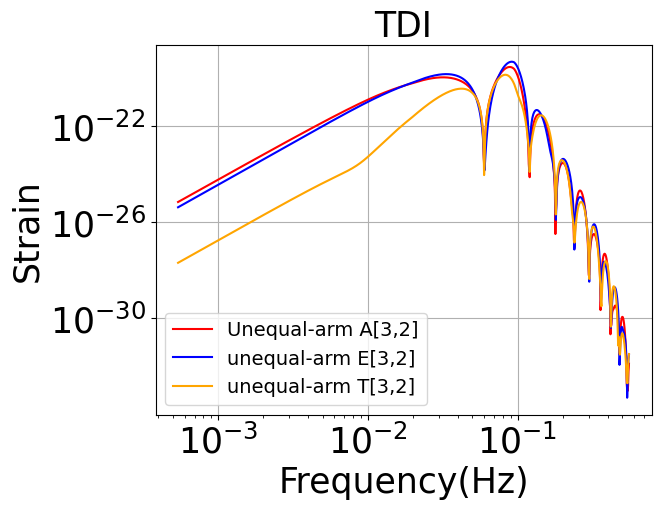

3 3


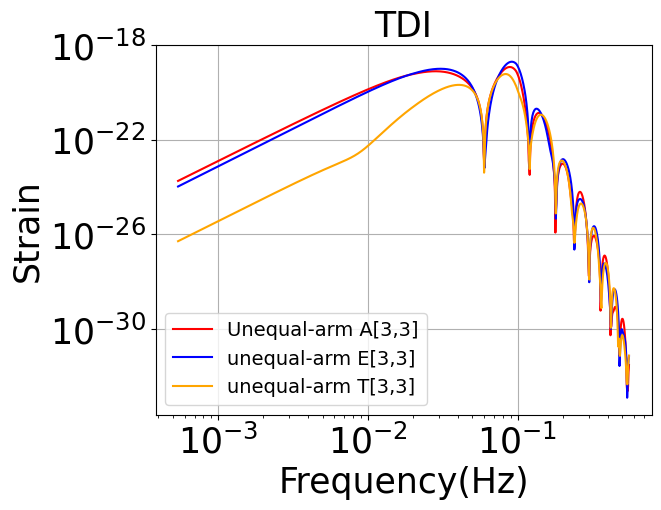

4 4


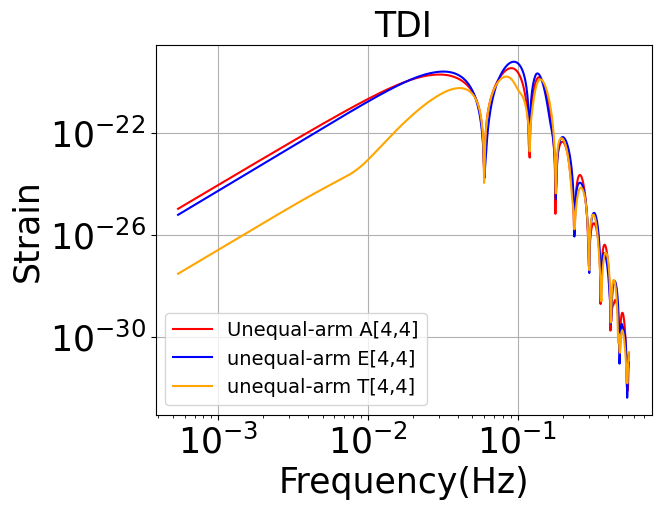

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(modes[1])):
    #f, ax = plt.subplots(1, 1, figsize=[12,8])
    l,m= modes[1][i]
    print(l,m)
    plt.loglog(tdiAET_unEQ[l,m]['freq'], np.abs(tdiAET_unEQ[l,m]['TDI1'])*tdiAET_unEQ[l,m]['freq'],label='Unequal-arm A[%d,%d]'%(l,m),linestyle='-',color='red')
    plt.loglog(tdiAET_unEQ[l,m]['freq'], np.abs(tdiAET_unEQ[l,m]['TDI2'])*tdiAET_unEQ[l,m]['freq'],label='unequal-arm E[%d,%d]'%(l,m),linestyle='-',color='blue')
    plt.loglog(tdiAET_unEQ[l,m]['freq'], np.abs(tdiAET_unEQ[l,m]['TDI3'])*tdiAET_unEQ[l,m]['freq'],label='unequal-arm T[%d,%d]'%(l,m),linestyle='-',color='orange')
    plt.xlabel('Frequency(Hz)',fontsize=25)
    plt.ylabel('Strain',fontsize=25)
    plt.tick_params(labelsize=25)
    #plt.xlim(1e-4,1e0)
    #plt.ylim(1e-30,1e-18)
    plt.title('TDI',fontsize=25)
    plt.legend(prop={'size':14})
    plt.grid()
    #plt.savefig('unequal_arm_TDIA.pdf',dpi=300)
    plt.show()
    plt.clf()

2 2


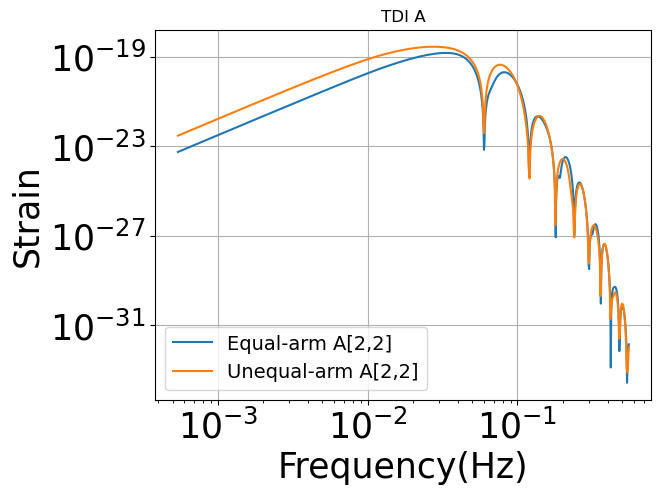

2 1


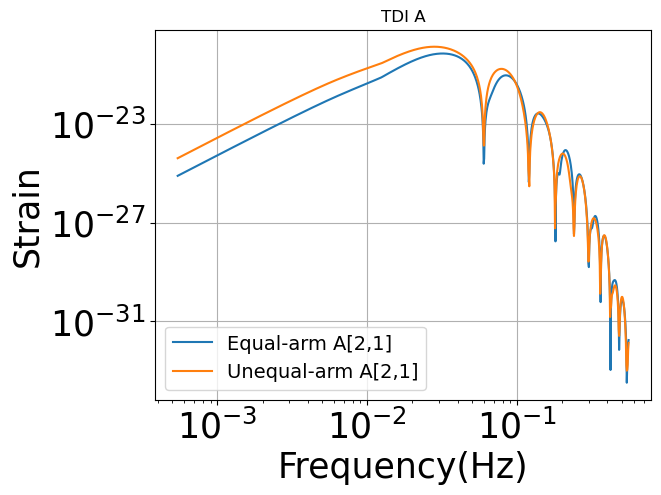

3 2


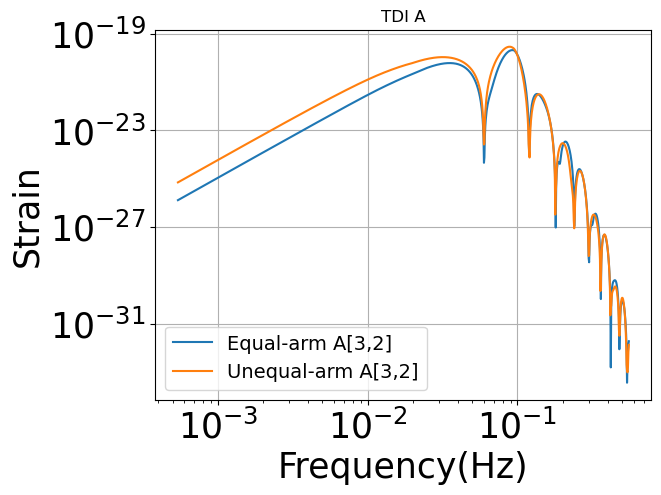

3 3


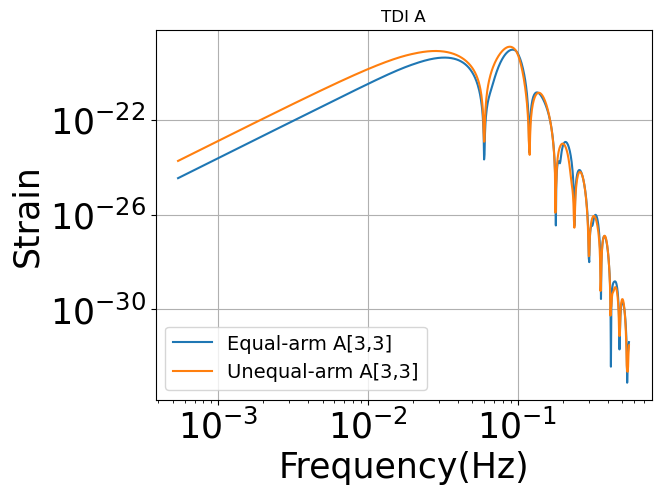

4 4


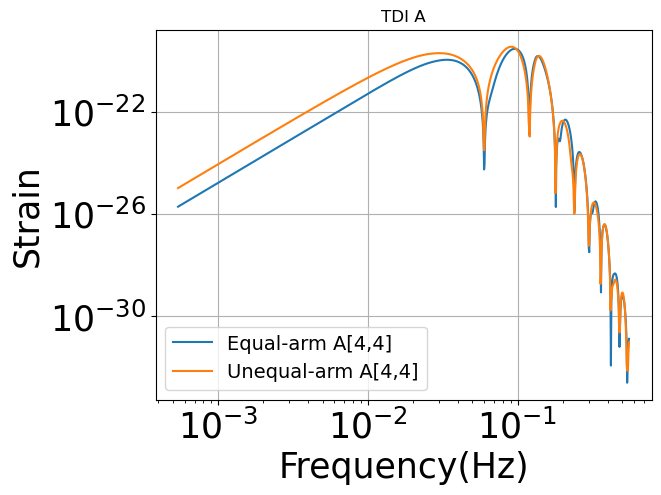

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(modes[1])):
    #f, ax = plt.subplots(1, 1, figsize=[12,8])
    l,m= modes[1][i]
    print(l,m)
    plt.loglog(tdiAET_EQ[l,m]['freq'], np.abs(tdiAET_EQ[l,m]['TDI1'])*tdiAET_EQ[l,m]['freq'],label='Equal-arm A[%d,%d]'%(l,m),linestyle='-')
    # plt.loglog(tdiAET_unEQ_EQ[l,m]['freq'], np.abs(tdiAET_unEQ_EQ[l,m]['TDI1'])*tdiAET_unEQ_EQ[l,m]['freq'],label='Proj. bais A[%d,%d]'%(l,m),linestyle='-')
    plt.loglog(tdiAET_unEQ[l,m]['freq'], np.abs(tdiAET_unEQ[l,m]['TDI1'])*tdiAET_unEQ[l,m]['freq'],label='Unequal-arm A[%d,%d]'%(l,m),linestyle='-')
    #plt.loglog(tmptdiAET[l,m]['freq'], np.abs(tmptdiAET[l,m]['TDI1'])*tmptdiAET[l,m]['freq'],label='A[%d,%d]'%(l,m),linestyle='-')
    plt.xlabel('Frequency(Hz)',fontsize=25)
    plt.ylabel('Strain',fontsize=25)
    plt.tick_params(labelsize=25)
    #plt.xlim(1e-4,1e0)
    #plt.ylim(1e-30,1e-18)
    plt.title('TDI A')
    plt.legend(prop={'size':14})
    plt.grid()
    #plt.savefig('unequal_arm_TDIA.pdf',dpi=300)
    plt.show()
    plt.clf()


2 2


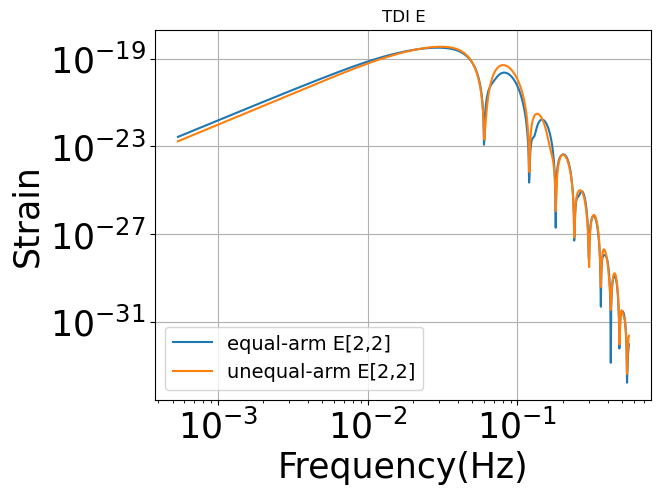

2 1


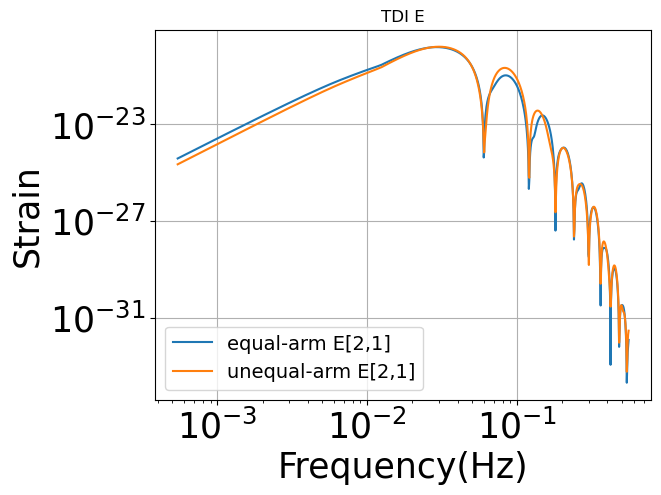

3 2


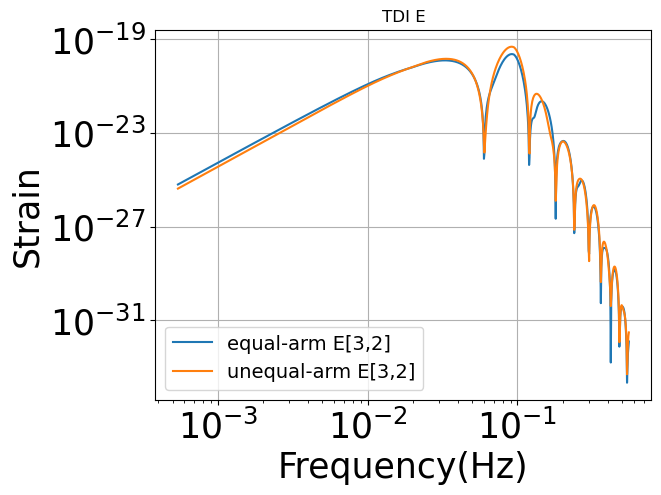

3 3


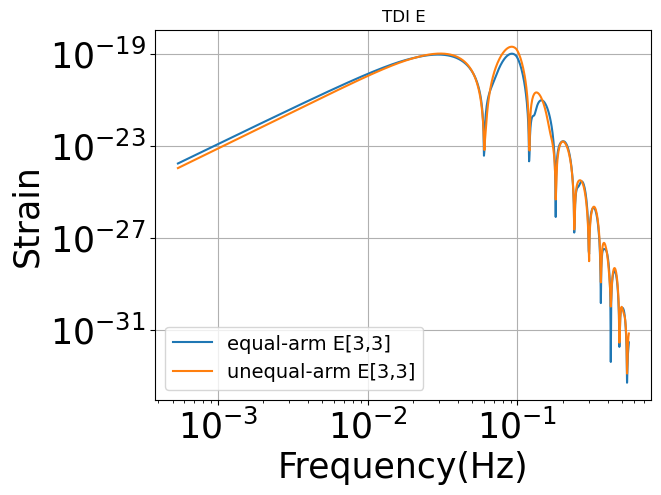

4 4


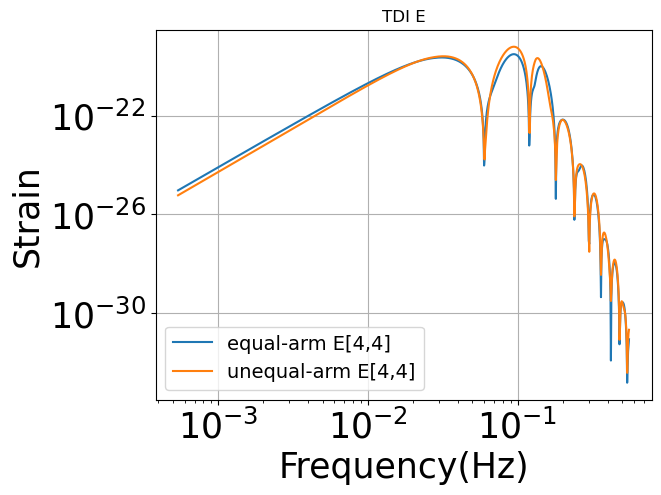

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(modes[1])):
    # f, ax = plt.subplots(1, 1, figsize=[12,8])
    l,m= modes[1][i]
    print(l,m)
    plt.loglog(tdiAET_EQ[l,m]['freq'], np.abs(tdiAET_EQ[l,m]['TDI2'])*tdiAET_EQ[l,m]['freq'],label='equal-arm E[%d,%d]'%(l,m),linestyle='-')
    # plt.loglog(tdiAET_unEQ_EQ[l,m]['freq'], np.abs(tdiAET_unEQ_EQ[l,m]['TDI2'])*tdiAET_unEQ_EQ[l,m]['freq'],label='Proj. bais E[%d,%d]'%(l,m),linestyle='-')
    plt.loglog(tdiAET_unEQ[l,m]['freq'], np.abs(tdiAET_unEQ[l,m]['TDI2'])*tdiAET_unEQ[l,m]['freq'],label='unequal-arm E[%d,%d]'%(l,m),linestyle='-')
    #plt.loglog(tmptdiAET[l,m]['freq'], np.abs(tmptdiAET[l,m]['TDI1'])*tmptdiAET[l,m]['freq'],label='A[%d,%d]'%(l,m),linestyle='-')
    plt.xlabel('Frequency(Hz)',fontsize=25)
    plt.ylabel('Strain',fontsize=25)
    plt.tick_params(labelsize=25)
    #plt.xlim(1e-4,1e0)
    #plt.ylim(1e-30,1e-18)
    plt.title('TDI E')
    plt.legend(prop={'size':14})
    plt.grid()
    #plt.savefig('unequal_arm_TDIE.pdf',dpi=300)
    plt.show()
    plt.clf()

2 2


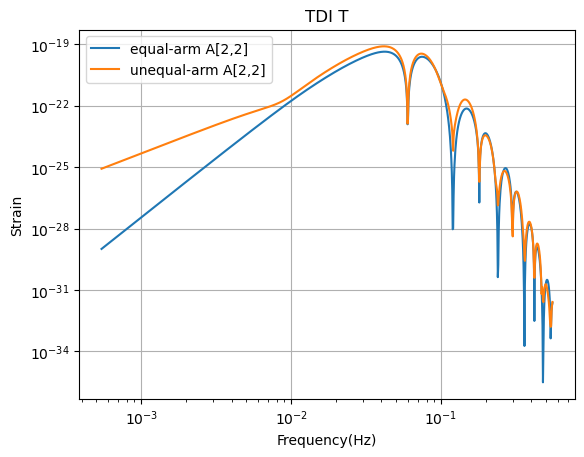

2 1


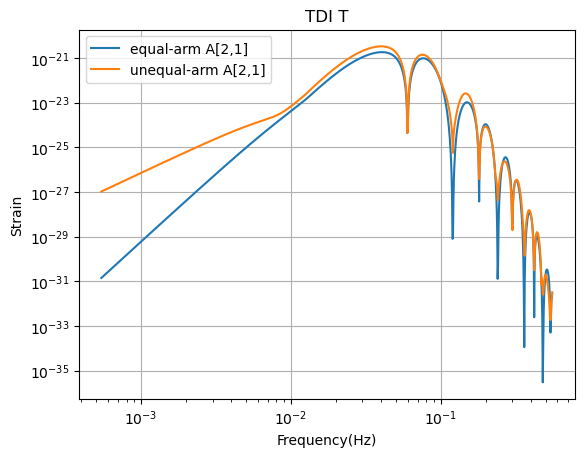

3 2


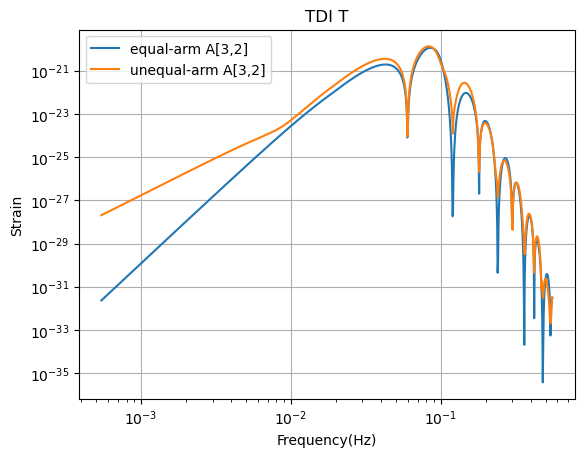

3 3


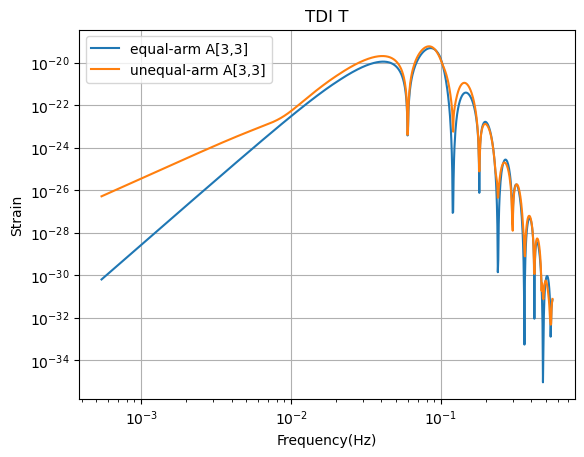

4 4


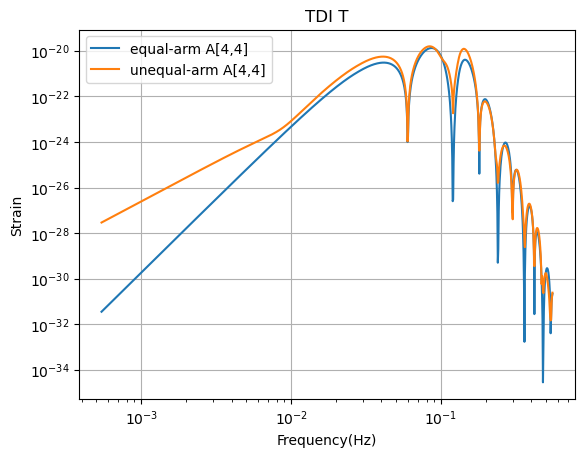

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    plt.loglog(tdiAET_EQ[l,m]['freq'], np.abs(tdiAET_EQ[l,m]['TDI3'])*tdiAET_EQ[l,m]['freq'],label='equal-arm A[%d,%d]'%(l,m),linestyle='-')
    # plt.loglog(tdiAET_unEQ_EQ[l,m]['freq'], np.abs(tdiAET_unEQ_EQ[l,m]['TDI3'])*tdiAET_unEQ_EQ[l,m]['freq'],label='Proj. bais A[%d,%d]'%(l,m),linestyle='-')
    plt.loglog(tdiAET_unEQ[l,m]['freq'], np.abs(tdiAET_unEQ[l,m]['TDI3'])*tdiAET_unEQ[l,m]['freq'],label='unequal-arm A[%d,%d]'%(l,m),linestyle='-')
    #plt.loglog(tmptdiAET[l,m]['freq'], np.abs(tmptdiAET[l,m]['TDI1'])*tmptdiAET[l,m]['freq'],label='A[%d,%d]'%(l,m),linestyle='-')
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Strain')
    #plt.xlim(1e-4,1e0)
    #plt.ylim(1e-30,1e-18)
    plt.title('TDI T')
    plt.legend()
    plt.grid()
    plt.show()
    plt.clf()

## The averaged response over sky and polarization

$$R^2_{\rm TDI}(f) = \frac{1}{4\pi^2}\int_{0}^{2\pi}\int_{-\frac{\pi}{2}}^{\frac{\pi}{2}}\int_{0}^{\pi}|\mathcal{T}(f,\iota=0)|^2\cos\beta \mathrm{d}\psi \mathrm{d}\beta \mathrm{d}\lambda $$

In [ ]:

# freq = logsampling(fmin/rescale,1e-1,1000)
N = 5
tmp_lambd = np.linspace(0.0,2.0*np.pi,N)
tmp_beta = np.linspace(-np.pi/2,np.pi/2,N)
tmp_psi = np.linspace(0.0,np.pi,N)
tmp_EQ= {}
tmp_unEQ= {}
# tmp_unEQ_EQ= {}
TDItag='TDIAET'
l,m= 2,2
print(l,m)
#inc = 0
for i in tqdm(range(N)):
    for j in range(N):
        for k in range(N):
            tmp_EQ[i,j,k]= FDresponseTDI(freq,hlm[l,m],0,tmp_lambd[i],tmp_beta[j],tmp_psi[k],phi0,[[l,m]],t0=t0, trajdict=trajdict, TDItag=TDItag,number_orbits=False,TDI_froze_arm=True,frozenLISA=True,rescaled=False)
            # tmp_unEQ_EQ[i,j,k]= FDresponseTDI(freq,hlm[l,m],inc=0,tmp_lambd[i],tmp_beta[j],tmp_psi[k],phi0,[[l,m]],t0=t0, trajdict=trajdict_numerical_orbits, TDItag=TDItag,TDI_froze_arm=True,frozenLISA=True,rescaled=False,responseapprox='full')
            tmp_unEQ[i,j,k]= FDresponseTDI(freq,hlm[l,m],0,tmp_lambd[i],tmp_beta[j],tmp_psi[k],phi0,[[l,m]],t0=t0, trajdict=trajdict_numerical_orbits, TDItag=TDItag,number_orbits=True,TDI_froze_arm=False,frozenLISA=True,rescaled=False)



2 2


100%|██████████| 5/5 [00:54<00:00, 10.97s/it]


In [ ]:
tmp_R_EQ = {}
tmp_R_EQ['averaged_transferL1'] = np.zeros(len(freq), dtype=np.complex128)
tmp_R_EQ['averaged_transferL2'] = np.zeros(len(freq), dtype=np.complex128)
tmp_R_EQ['averaged_transferL3'] = np.zeros(len(freq), dtype=np.complex128)
# tmp_R_unEQ_EQ = {}
# tmp_R_unEQ_EQ['averaged_transferL1'] = np.zeros(len(freq), dtype=np.complex128)
# tmp_R_unEQ_EQ['averaged_transferL2'] = np.zeros(len(freq), dtype=np.complex128)
# tmp_R_unEQ_EQ['averaged_transferL3'] = np.zeros(len(freq), dtype=np.complex128)
tmp_R_unEQ = {}
tmp_R_unEQ['averaged_transferL1'] = np.zeros(len(freq), dtype=np.complex128)
tmp_R_unEQ['averaged_transferL2'] = np.zeros(len(freq), dtype=np.complex128)
tmp_R_unEQ['averaged_transferL3'] = np.zeros(len(freq), dtype=np.complex128)
for i in tqdm(range(N)):
    for j in range(N):
        for k in range(N):
            tmp_R_EQ['averaged_transferL1']+= np.abs(tmp_EQ[i,j,k]['transferL1'])**2*np.cos(tmp_beta[j])*(tmp_psi[1]-tmp_psi[0])*(tmp_beta[1]-tmp_beta[0])*(tmp_lambd[1]-tmp_lambd[0])
            tmp_R_EQ['averaged_transferL2']+= np.abs(tmp_EQ[i,j,k]['transferL2'])**2*np.cos(tmp_beta[j])*(tmp_psi[1]-tmp_psi[0])*(tmp_beta[1]-tmp_beta[0])*(tmp_lambd[1]-tmp_lambd[0])
            tmp_R_EQ['averaged_transferL3']+= np.abs(tmp_EQ[i,j,k]['transferL3'])**2*np.cos(tmp_beta[j])*(tmp_psi[1]-tmp_psi[0])*(tmp_beta[1]-tmp_beta[0])*(tmp_lambd[1]-tmp_lambd[0])
            # tmp_R_unEQ_EQ['averaged_transferL1']+= np.abs(tmp_unEQ_EQ[i,j,k]['transferL1'])**2*np.cos(tmp_beta[j])*(tmp_psi[1]-tmp_psi[0])*(tmp_beta[1]-tmp_beta[0])*(tmp_lambd[1]-tmp_lambd[0])
            # tmp_R_unEQ_EQ['averaged_transferL2']+= np.abs(tmp_unEQ_EQ[i,j,k]['transferL2'])**2*np.cos(tmp_beta[j])*(tmp_psi[1]-tmp_psi[0])*(tmp_beta[1]-tmp_beta[0])*(tmp_lambd[1]-tmp_lambd[0])
            # tmp_R_unEQ_EQ['averaged_transferL3']+= np.abs(tmp_unEQ_EQ[i,j,k]['transferL3'])**2*np.cos(tmp_beta[j])*(tmp_psi[1]-tmp_psi[0])*(tmp_beta[1]-tmp_beta[0])*(tmp_lambd[1]-tmp_lambd[0])
            tmp_R_unEQ['averaged_transferL1']+= np.abs(tmp_unEQ[i,j,k]['transferL1'])**2*np.cos(tmp_beta[j])*(tmp_psi[1]-tmp_psi[0])*(tmp_beta[1]-tmp_beta[0])*(tmp_lambd[1]-tmp_lambd[0])
            tmp_R_unEQ['averaged_transferL2']+= np.abs(tmp_unEQ[i,j,k]['transferL2'])**2*np.cos(tmp_beta[j])*(tmp_psi[1]-tmp_psi[0])*(tmp_beta[1]-tmp_beta[0])*(tmp_lambd[1]-tmp_lambd[0])
            tmp_R_unEQ['averaged_transferL3']+= np.abs(tmp_unEQ[i,j,k]['transferL3'])**2*np.cos(tmp_beta[j])*(tmp_psi[1]-tmp_psi[0])*(tmp_beta[1]-tmp_beta[0])*(tmp_lambd[1]-tmp_lambd[0])

100%|██████████| 5/5 [00:00<00:00, 145.13it/s]


/disk1/home/wrjx/anaconda2/envs/litepig/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/disk1/home/wrjx/anaconda2/envs/litepig/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


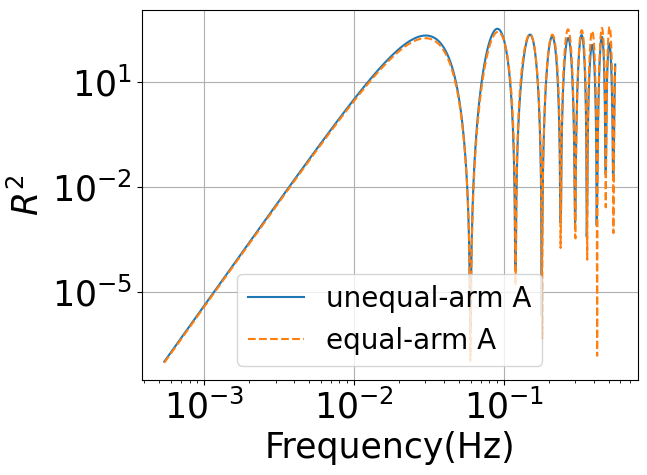

/disk1/home/wrjx/anaconda2/envs/litepig/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/disk1/home/wrjx/anaconda2/envs/litepig/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


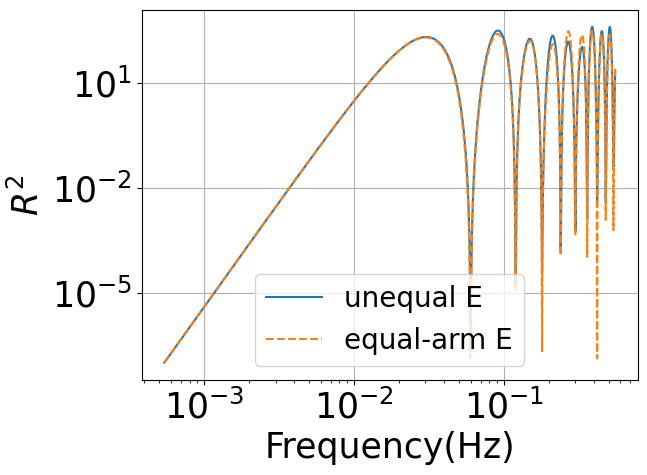

/disk1/home/wrjx/anaconda2/envs/litepig/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/disk1/home/wrjx/anaconda2/envs/litepig/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


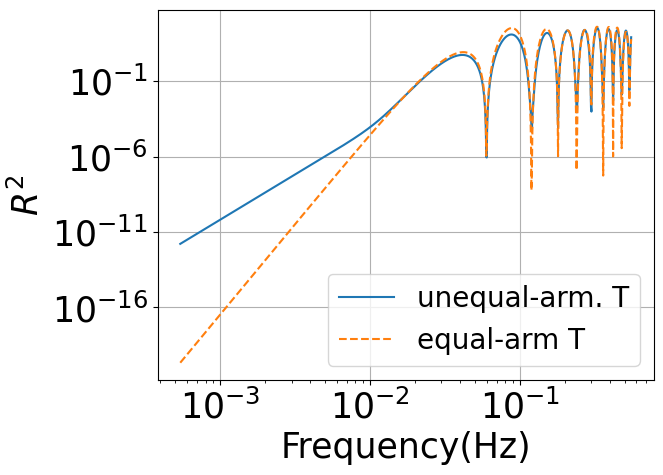

<Figure size 640x480 with 0 Axes>

In [ ]:
#f, ax = plt.subplots(1, 1, figsize=[12,9])
plt.loglog(freq,tmp_R_unEQ['averaged_transferL1'],label='unequal-arm A')
# plt.loglog(freq,tmp_R_unEQ_EQ['averaged_transferL1'],label='Proj. A')
plt.loglog(freq,tmp_R_EQ['averaged_transferL1'],label='equal-arm A',linestyle='--')
plt.xlabel('Frequency(Hz)',fontsize=25)
plt.ylabel('$R^2$',fontsize=25)
plt.tick_params(labelsize=25)
#plt.xlim(1e-4,1e0)
#plt.ylim(1e-30,1e-18)
# plt.title('TDI A')
plt.legend(prop={'size':20})
plt.grid()
plt.show()
plt.clf()

#f, ax = plt.subplots(1, 1, figsize=[12,9])
plt.loglog(freq,tmp_R_unEQ['averaged_transferL2'],label='unequal E')
# plt.loglog(freq,tmp_R_unEQ_EQ['averaged_transferL2'],label='Proj. E')
plt.loglog(freq,tmp_R_EQ['averaged_transferL2'],label='equal-arm E',linestyle='--')
plt.xlabel('Frequency(Hz)',fontsize=25)
plt.ylabel('$R^2$',fontsize=25)
plt.tick_params(labelsize=25)
#plt.xlim(1e-4,1e0)
#plt.ylim(1e-30,1e-18)
# plt.title('TDI A')
plt.legend(prop={'size':20})
plt.grid()
plt.show()
plt.clf()

#f, ax = plt.subplots(1, 1, figsize=[12,9])
plt.loglog(freq,tmp_R_unEQ['averaged_transferL3'],label='unequal-arm. T')
# plt.loglog(freq,tmp_R_unEQ_EQ['averaged_transferL3'],label='Proj. T')
plt.loglog(freq,tmp_R_EQ['averaged_transferL3'],label='equal-arm T',linestyle='--')
plt.xlabel('Frequency(Hz)',fontsize=25)
plt.ylabel('$R^2$',fontsize=25)
plt.tick_params(labelsize=25)
#plt.xlim(1e-4,1e0)
#plt.ylim(1e-30,1e-18)
# plt.title('TDI A')
plt.legend(prop={'size':20})
plt.grid()
plt.show()
plt.clf()